# Optimising cluster shape properties with new algorithm

This algorithm uses triangles of different sizes:

1. P0113  (to be included soon)
2. P016
3. P03
4. P045

Together with the generator level information, we will use these three different sizes for three different studies and try to understand the impact of granularity on cluster properties.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import seaborn as sns
import analysis as ana
import os, time, datetime, shutil, json, pathlib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import make_hastie_10_2
from pandas.api.types import is_float_dtype, is_integer_dtype
from math import ceil, log2
from scipy.special import softmax
import conifer, shap
from typing import Optional, Dict, Mapping, Union
from pathlib import Path

Could not import conifer ydf converter
runtime module could not be imported. Interacting with accelerators will not be possible.
runtime module could not be imported. Interacting with FPUs will not be possible.


In [2]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

### Path to the files

In [3]:
# Photon files
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgogen_filtered.h5"
photon_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_Ref_filtered.h5"
photon_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p0113_filtered.h5"
photon_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p016_filtered.h5"
photon_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p03_filtered.h5"
photon_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p045_filtered.h5"

# QCD files
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgogen_filtered.h5"
qcd_PU200_genpart = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgogenpart_filtered.h5"
qcd_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_Ref_filtered.h5"
qcd_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p0113_filtered.h5"
qcd_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p016_filtered.h5"
qcd_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p03_filtered.h5"
qcd_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p045_filtered.h5"

# Pion files
pion_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgogen_filtered.h5"
pion_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_Ref_filtered.h5"
pion_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p0113_filtered.h5"
pion_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p016_filtered.h5"
pion_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p03_filtered.h5"
pion_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p045_filtered.h5"

# PU200 files
PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_Ref_filtered.h5"
PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p0113_filtered.h5"
PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p016_filtered.h5"
PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p03_filtered.h5"
PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p045_filtered.h5"

In [4]:
photon_df_Ref = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_Ref)
photon_df_p0113 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p0113)
photon_df_p016 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p016)
photon_df_p03 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p03)
photon_df_p045 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p045)

In [5]:
count = (photon_df_p0113['genpart_gen'] != -1).sum()
print(count)

214342


In [6]:
print(photon_df_p03.columns.tolist())

['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'gen_energy', 'gen_pdgid', 'gen_status', 'genpart_exphi', 'genpart_exeta', 'genpart_gen', 'genpart_reachedEE', 'cl3d_p03Tri_pt', 'cl3d_p03Tri_energy', 'cl3d_p03Tri_eta', 'cl3d_p03Tri_phi', 'cl3d_p03Tri_showerlength', 'cl3d_p03Tri_coreshowerlength', 'cl3d_p03Tri_firstlayer', 'cl3d_p03Tri_maxlayer', 'cl3d_p03Tri_varrr', 'cl3d_p03Tri_varzz', 'cl3d_p03Tri_varee', 'cl3d_p03Tri_varpp', 'cl3d_p03Tri_emaxe', 'cl3d_p03Tri_hoe', 'cl3d_p03Tri_meanz', 'cl3d_p03Tri_first1layers', 'cl3d_p03Tri_first3layers', 'cl3d_p03Tri_first5layers', 'cl3d_p03Tri_firstHcal1layers', 'cl3d_p03Tri_firstHcal3layers', 'cl3d_p03Tri_firstHcal5layers', 'cl3d_p03Tri_last1layers', 'cl3d_p03Tri_last3layers', 'cl3d_p03Tri_last5layers', 'cl3d_p03Tri_emax1layers', 'cl3d_p03Tri_emax3layers', 'cl3d_p03Tri_emax5layers', 'cl3d_p03Tri_eot', 'cl3d_p03Tri_ebm0', 'cl3d_p03Tri_ebm1', 'cl3d_p03Tri_hbm']


In [7]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p0113 = pd.read_hdf(PU200_cl3d_p0113)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

In [8]:
pion_df_Ref = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p0113 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p0113)
pion_df_p016 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p045)

In [9]:
pion_df_p016

,event,gen_n,gen_eta,gen_phi,gen_pt,gen_energy,gen_pdgid,gen_status,genpart_exphi,genpart_exeta,...,cl3d_p016Tri_last1layers,cl3d_p016Tri_last3layers,cl3d_p016Tri_last5layers,cl3d_p016Tri_emax1layers,cl3d_p016Tri_emax3layers,cl3d_p016Tri_emax5layers,cl3d_p016Tri_eot,cl3d_p016Tri_ebm0,cl3d_p016Tri_ebm1,cl3d_p016Tri_hbm
0,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,-1.275067,-1.769644,...,0.000000,0.000000,0.000000,0.073599,0.214842,0.353606,0.509359,8191,4080,4193280
1,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,-1.275067,-1.769644,...,0.000000,0.000000,0.000000,0.002587,0.005775,0.008434,0.566726,4095,15,4192256
2,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,1.848477,1.795015,...,0.000000,0.000000,0.000000,0.073599,0.214842,0.353606,0.509359,8191,4080,4193280
3,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,1.848477,1.795015,...,0.000000,0.000000,0.000000,0.002587,0.005775,0.008434,0.566726,4095,15,4192256
4,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,0.272946,0.201797,...,0.000000,0.000000,0.000000,0.073599,0.214842,0.353606,0.509359,8191,4080,4193280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447209,8987,2,-2.778728,-1.413706,144.859299,1170.510132,211,1,2.970383,0.927353,...,0.000994,0.002979,0.016061,0.002123,0.005513,0.006811,0.028187,7149,8,4194303
1447210,8987,2,-2.778728,-1.413706,144.859299,1170.510132,211,1,1.425296,-0.338723,...,0.000460,0.003185,0.018773,0.057085,0.189659,0.357477,0.744865,8191,4095,4194303
1447211,8987,2,-2.778728,-1.413706,144.859299,1170.510132,211,1,1.425296,-0.338723,...,0.000994,0.002979,0.016061,0.002123,0.005513,0.006811,0.028187,7149,8,4194303
1447212,8987,2,-2.778728,-1.413706,144.859299,1170.510132,211,1,-2.427279,0.789054,...,0.000460,0.003185,0.018773,0.057085,0.189659,0.357477,0.744865,8191,4095,4194303


In [10]:
print(pion_df_p016.columns.tolist())

['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'gen_energy', 'gen_pdgid', 'gen_status', 'genpart_exphi', 'genpart_exeta', 'genpart_gen', 'genpart_reachedEE', 'cl3d_p016Tri_pt', 'cl3d_p016Tri_energy', 'cl3d_p016Tri_eta', 'cl3d_p016Tri_phi', 'cl3d_p016Tri_showerlength', 'cl3d_p016Tri_coreshowerlength', 'cl3d_p016Tri_firstlayer', 'cl3d_p016Tri_maxlayer', 'cl3d_p016Tri_varrr', 'cl3d_p016Tri_varzz', 'cl3d_p016Tri_varee', 'cl3d_p016Tri_varpp', 'cl3d_p016Tri_emaxe', 'cl3d_p016Tri_hoe', 'cl3d_p016Tri_meanz', 'cl3d_p016Tri_first1layers', 'cl3d_p016Tri_first3layers', 'cl3d_p016Tri_first5layers', 'cl3d_p016Tri_firstHcal1layers', 'cl3d_p016Tri_firstHcal3layers', 'cl3d_p016Tri_firstHcal5layers', 'cl3d_p016Tri_last1layers', 'cl3d_p016Tri_last3layers', 'cl3d_p016Tri_last5layers', 'cl3d_p016Tri_emax1layers', 'cl3d_p016Tri_emax3layers', 'cl3d_p016Tri_emax5layers', 'cl3d_p016Tri_eot', 'cl3d_p016Tri_ebm0', 'cl3d_p016Tri_ebm1', 'cl3d_p016Tri_hbm']


In [10]:
qcd_df_Ref = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p0113 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p0113)
qcd_df_p016 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p045)

### Until this point, it is evident that with coarser granularity, the number of clusters increase!

In [11]:
# Delta r filter
qcd_df_Ref_filtered = ana.filter_by_delta_r(qcd_df_Ref, "cl3d_Ref", 0.5)
qcd_df_p0113_filtered = ana.filter_by_delta_r(qcd_df_p0113, "cl3d_p0113Tri", 0.5)
qcd_df_p016_filtered = ana.filter_by_delta_r(qcd_df_p016, "cl3d_p016Tri", 0.5)
qcd_df_p03_filtered = ana.filter_by_delta_r(qcd_df_p03, "cl3d_p03Tri", 0.5)
qcd_df_p045_filtered = ana.filter_by_delta_r(qcd_df_p045, "cl3d_p045Tri", 0.5)

In [12]:
# Delta r filter
pion_df_Ref_filtered = ana.filter_by_delta_r(pion_df_Ref, "cl3d_Ref", 0.1)
pion_df_p0113_filtered = ana.filter_by_delta_r(pion_df_p0113, "cl3d_p0113Tri", 0.1)
pion_df_p016_filtered = ana.filter_by_delta_r(pion_df_p016, "cl3d_p016Tri", 0.1)
pion_df_p03_filtered = ana.filter_by_delta_r(pion_df_p03, "cl3d_p03Tri", 0.1)
pion_df_p045_filtered = ana.filter_by_delta_r(pion_df_p045, "cl3d_p045Tri", 0.1)

In [15]:
pion_df_Ref_filtered

,event,gen_n,gen_eta,gen_phi,gen_pt,gen_energy,gen_pdgid,gen_status,genpart_exphi,genpart_exeta,...,cl3d_Ref_last3layers,cl3d_Ref_last5layers,cl3d_Ref_emax1layers,cl3d_Ref_emax3layers,cl3d_Ref_emax5layers,cl3d_Ref_eot,cl3d_Ref_ebm0,cl3d_Ref_ebm1,cl3d_Ref_hbm,delta_r
0,2,2,-2.140688,0.063388,155.417755,670.072693,-211,1,0.066218,-2.122293,...,0.034106,0.050061,0.000259,0.007225,0.036062,0.465306,2047,31,4193951,0.002555
1,4,2,2.008824,-1.423094,197.620239,749.839844,-211,1,1.715938,-1.985335,...,0.000000,0.000000,0.126325,0.375197,0.603609,0.948526,8191,4094,3911424,0.001522
2,7,2,2.316888,2.342615,79.190742,405.561157,-211,1,2.347152,2.320733,...,0.000000,0.000000,0.088010,0.299319,0.495011,0.891149,8191,4094,4192256,0.002599
3,18,2,1.871927,1.228619,64.288452,213.908295,-211,1,-1.921850,-1.871683,...,0.000000,0.000000,0.041885,0.094923,0.149268,0.525306,8191,127,4186240,0.000868
4,23,2,2.309355,0.194885,89.383324,454.391510,-211,1,-2.950760,-2.312781,...,0.000000,0.000000,0.109439,0.291870,0.439076,0.679485,3071,511,4193408,0.006646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891,39993,2,-2.484129,-0.863625,136.821289,825.994690,-211,1,2.275695,2.473782,...,0.000000,0.001905,0.093619,0.269587,0.410837,0.644504,8191,4095,4194224,0.002707
7892,39994,2,2.525425,-0.699443,170.648468,1073.057617,-211,1,-0.697693,2.513133,...,0.002631,0.002631,0.153519,0.457407,0.696814,0.991624,8191,4094,3346436,0.005043
7893,39996,2,-2.230999,0.238218,116.088264,546.577393,-211,1,0.241681,-2.205984,...,0.000000,0.000000,0.000000,0.000458,0.000931,0.005318,6024,0,2097120,0.005353
7894,39998,2,-1.853970,-2.147918,91.232704,298.410034,-211,1,-2.141421,-1.833268,...,0.000000,0.000000,0.000676,0.000676,0.005860,0.432769,8031,15,4192768,0.003320


## Let's begin the multi-class BDT

In [13]:
'''# Ref
photon_df_Ref_filtered['label'] = 0
pion_df_Ref_filtered['label'] = 3
qcd_df_Ref_filtered['label'] = 2
PU_df_Ref['label'] = 1'''

# p016
photon_df_p016_filtered['label'] = 0
pion_df_p016_filtered['label'] = 3
qcd_df_p016_filtered['label'] = 2
PU_df_p016['label'] = 1

'''# p03
photon_df_p03_filtered['label'] = 0
pion_df_p03_filtered['label'] = 3
qcd_df_p03_filtered['label'] = 2
PU_df_p03['label'] = 1'''

'''# p045
photon_df_p045_filtered['label'] = 0
pion_df_p045_filtered['label'] = 3
qcd_df_p045_filtered['label'] = 2
PU_df_p045['label'] = 1'''

"# p045\nphoton_df_p045_filtered['label'] = 0\npion_df_p045_filtered['label'] = 3\nqcd_df_p045_filtered['label'] = 2\nPU_df_p045['label'] = 1"

In [14]:
all_dfs = [qcd_df_p016_filtered, photon_df_p016_filtered, PU_df_p016]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][ana.columns_for_training('p016Tri') + ['label']]

In [15]:
all_dfs = [qcd_df_p016_filtered, photon_df_p016_filtered, PU_df_p016, pion_df_p016_filtered]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][ana.columns_for_training('p016Tri') + ['label']]

In [16]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [19]:
X = df_combined[ana.columns_for_training('p016Tri')]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)


In [17]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)

In [18]:
model = xgb.XGBClassifier(
    objective='auc',
    num_class=4,
    max_depth=5,
    n_estimators=45,
    learning_rate=0.001,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [19]:
model.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=45, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2]), y_pred_proba, multi_class='ovr')

print(f"\n✅ Accuracy: {acc:.3f}")
print("🔢 Confusion Matrix:\n", conf_mat)
print(f"📈 ROC AUC (OvR): {roc_auc:.3f}")


✅ Accuracy: 0.938
🔢 Confusion Matrix:
 [[4278   44   99]
 [  42 1556  117]
 [ 104  134 2357]]
📈 ROC AUC (OvR): 0.985


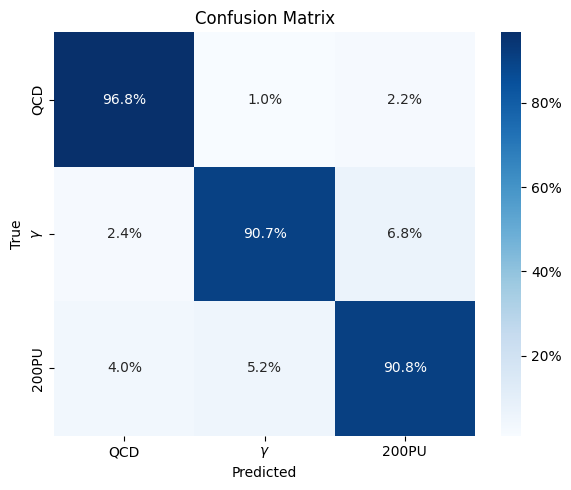

In [21]:
# Row-normalize to percentages
class_names = ['QCD', r'$\gamma$', '200PU', 'Pions']
conf_mat = np.asarray(conf_mat, dtype=float)
row_sums = conf_mat.sum(axis=1, keepdims=True)
conf_mat_pct = np.divide(conf_mat, row_sums, out=np.zeros_like(conf_mat), where=row_sums!=0) * 100.0

# Make pretty percent labels
annot_labels = np.array([[f"{v:.1f}%" for v in row] for row in conf_mat_pct])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_pct, annot=annot_labels, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={"format": '%.0f%%'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_percent.png", dpi=300)
plt.show()

In [22]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

# Normalise by true class totals (row-wise)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

roc_auc = roc_auc_score(
    label_binarize(y_test, classes=[0, 1, 2, 3]),
    y_pred_proba,
    multi_class='ovr'
)

print(f"\n✅ Accuracy: {acc*100:.2f}%")
print("🔢 Normalised Confusion Matrix (%):\n", np.round(conf_mat_norm, 2))
print(f"📈 ROC AUC (OvR): {roc_auc*100:.2f}%")


✅ Accuracy: 93.82%
🔢 Normalised Confusion Matrix (%):
 [[96.77  1.    2.24]
 [ 2.45 90.73  6.82]
 [ 4.01  5.16 90.83]]
📈 ROC AUC (OvR): 98.51%


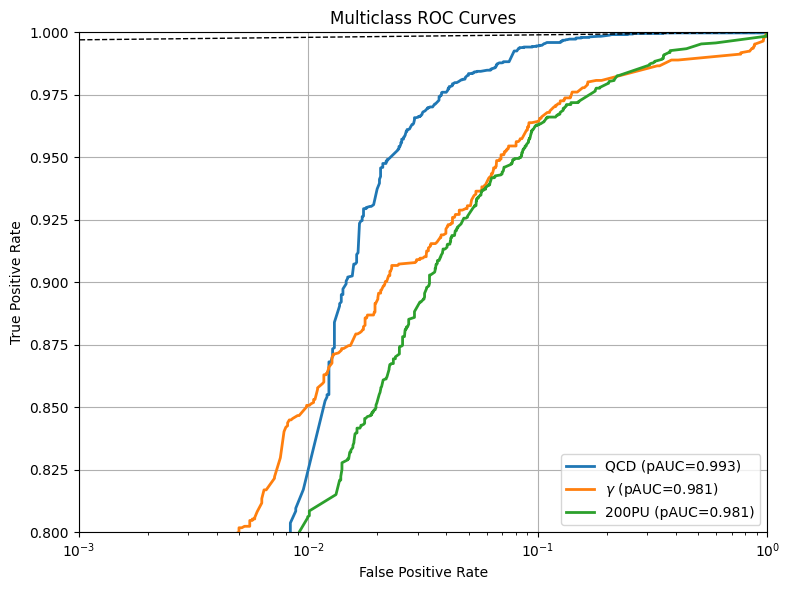

In [23]:
thr = 0.8  # signal efficiency threshold
n_classes = 4
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = {}
tpr = {}
roc_auc = {}
partial_auc = {}

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    # ROC
    fpr_full, tpr_full, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr_full, tpr_full)

    # Keep only points with TPR >= 0.8
    mask = tpr_full >= 0
    if np.sum(mask) > 1:
        fpr[i], tpr[i] = fpr_full[mask], tpr_full[mask]
        partial_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{class_names[i]} (pAUC={partial_auc[i]:.3f})")
    else:
        fpr[i], tpr[i] = None, None
        partial_auc[i] = np.nan

# Diagonal line (optional)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.001, 1.0])
plt.ylim([thr, 1.0])  # zoom into TPR >= 0.8
plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("multiclass_roc_partial.png", dpi=300)
plt.show()

In [80]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap_vals_pion = shap_values[:, :, 3]
shap.summary_plot(shap_vals_pion, X_test, feature_names=ana.columns_for_training('p045Tri'), show=True)

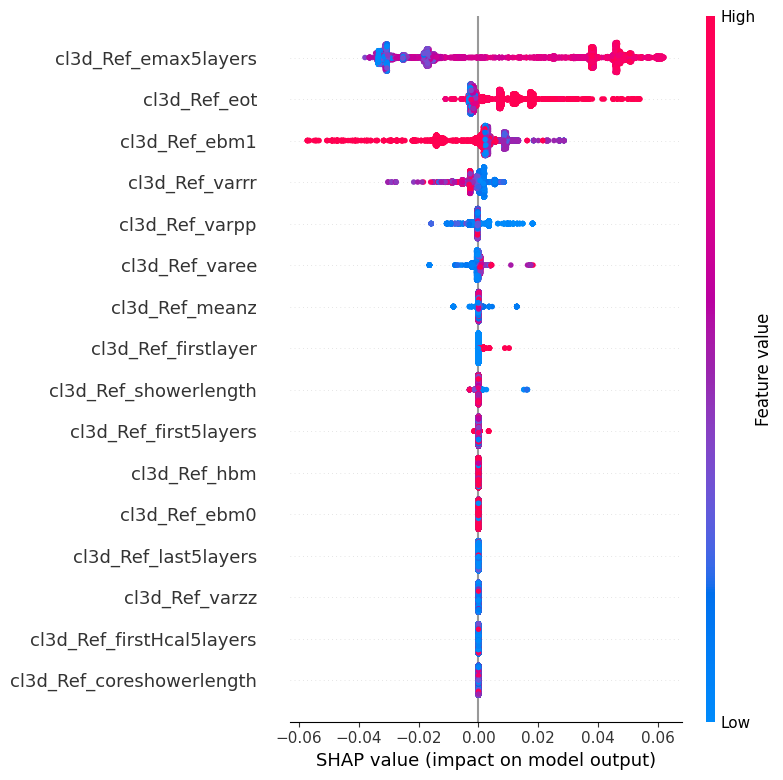

In [27]:
shap_vals_egamma = shap_values[:, :, 0]
shap.summary_plot(shap_vals_egamma, X_test, feature_names=ana.columns_for_training('Ref'), show=True)

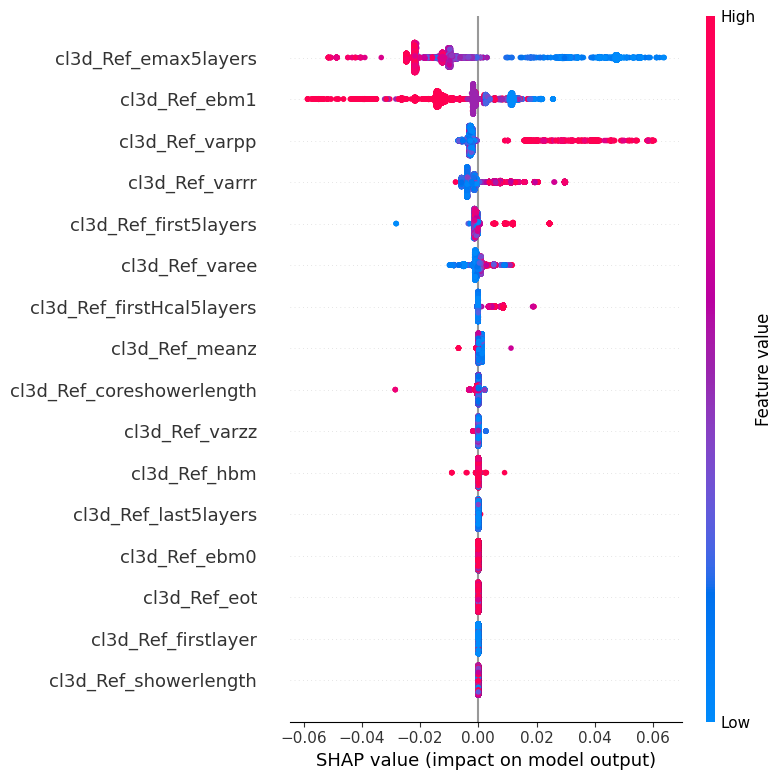

In [28]:
shap_vals_pu = shap_values[:, :, 1]
shap.summary_plot(shap_vals_pu, X_test, feature_names=ana.columns_for_training('Ref'), show=True)

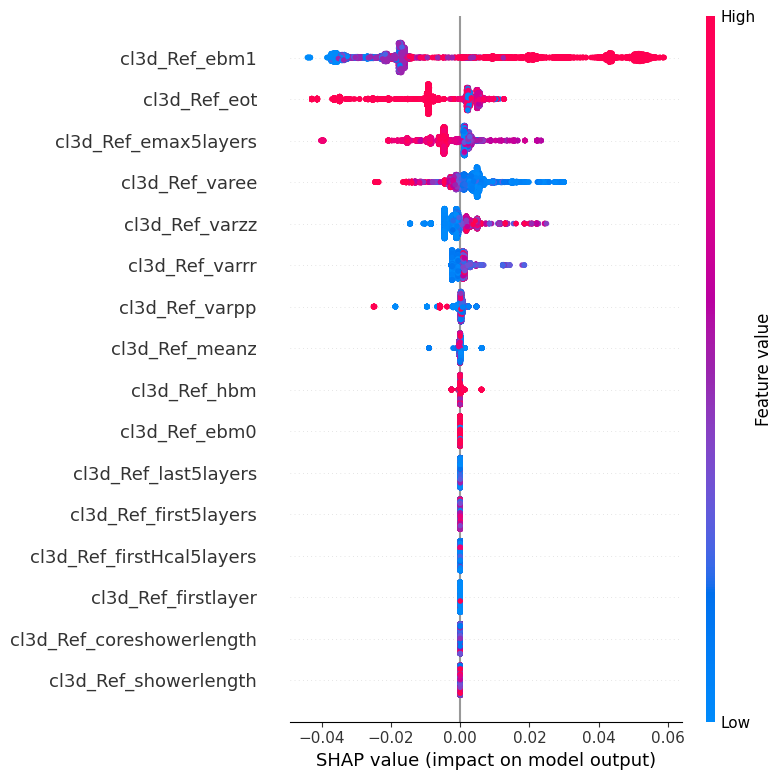

In [29]:
shap_vals_qcd = shap_values[:, :, 2]
shap.summary_plot(shap_vals_qcd, X_test, feature_names=ana.columns_for_training('Ref'), show=True)

In [30]:
!which vitis_hls

/data/elec_soft/Xilinx_Software/Soft_2022.2/Vitis_HLS/2022.2/bin/vitis_hls


## The Bit Budget

## Let's start the conifer implementation

In [31]:
def maxbits(series: pd.Series, maxbit: int) -> int:
    """Floats -> maxbit. Int-like -> smallest bits to cover unique values (capped by maxbit)."""
    if is_float_dtype(series):
        return int(maxbit)
    uniq = pd.unique(series.dropna())
    nval = max(1, len(uniq))
    bits_needed = 1 if nval <= 2 else ceil(log2(nval))
    return int(min(maxbit, max(1, bits_needed)))

def _learn_edges(x: np.ndarray, nbits: int, method: str, fmin=None, fmax=None):
    """Return monotone bin edges of length nbins+1."""
    nbins = 2**nbits
    x = x[np.isfinite(x)]
    if x.size == 0:
        # degenerate; dummy edges
        return np.array([0, 1], dtype=float)

    lo = np.min(x) if fmin is None else float(fmin)
    hi = np.max(x) if fmax is None else float(fmax)
    if not (hi > lo):
        # constant -> two close edges
        return np.array([lo, lo+1e-9], dtype=float)

    if method == 'uniform':
        edges = np.linspace(lo, hi, nbins+1, endpoint=True)
    elif method == 'percentile':
        qs = np.linspace(0, 100, nbins+1)
        edges = np.percentile(x, qs)
        # enforce monotonicity & degen fallback
        edges = np.maximum.accumulate(edges)
        if not (edges[-1] > edges[0]):
            edges = np.linspace(lo, hi, nbins+1, endpoint=True)
    else:
        raise ValueError("method must be 'uniform' or 'percentile'")
    return edges

def _digitize_codes(x: np.ndarray, edges: np.ndarray, keep_nan_code: int = -1):
    """Digitize to 0..nbins-1, set NaN/inf to keep_nan_code."""
    codes = np.full(x.shape, keep_nan_code, dtype=np.int32)
    finite = np.isfinite(x)
    if finite.any():
        idx = np.digitize(x[finite], edges, right=True)  # 0..nbins
        nbins = len(edges) - 1
        idx = np.clip(idx, 1, nbins) - 1               # 0..nbins-1
        codes[finite] = idx.astype(np.int32, copy=False)
    return codes

def fit_quantizers(
    X_train: pd.DataFrame,
    maxbit: int = 8,
    float_method: str = 'percentile',
    int_method: str = 'uniform',
    per_feature_bits: Optional[Mapping[str, int]] = None,   # <- fix here
):
    """
    Learn quantization edges per feature on the *training set*.
    Returns dict: {feat: {'nbits', 'edges', 'method'}}.
    """
    qs: Dict[str, Dict[str, object]] = {}
    for c in X_train.columns:
        s = X_train[c]
        # choose bits
        nbits = per_feature_bits[c] if (per_feature_bits is not None and c in per_feature_bits) else maxbits(s, maxbit)
        # choose method
        method = int_method if is_integer_dtype(s) else float_method
        # coerce to float for robust finite handling
        x = pd.to_numeric(s, errors='coerce').to_numpy(dtype='float64', copy=False)
        edges = _learn_edges(x, nbits=nbits, method=method)
        qs[c] = {'nbits': nbits, 'edges': edges, 'method': method}
    return qs
def transform_quantizers(X: pd.DataFrame, qspec: dict, keep_nan_code: int = -1) -> pd.DataFrame:
    """
    Apply learned quantizers to any DataFrame of same columns.
    Returns a new DataFrame of integer codes.
    """
    out = {}
    for c, spec in qspec.items():
        x = pd.to_numeric(X[c], errors='coerce').to_numpy(dtype='float64', copy=False)
        out[c] = _digitize_codes(x, spec['edges'], keep_nan_code=keep_nan_code)
    Q = pd.DataFrame(out, index=X.index)[X.columns]  # preserve column order
    return Q

def count_total_splits(booster: xgb.Booster) -> int:
    df = booster.trees_to_dataframe()
    # internal nodes have Feature != 'Leaf'
    return int((df['Feature'] != 'Leaf').sum())

# ---- timing helper for bridge inference ----
def timed_decision_function(model, X_np):
    t0 = time.perf_counter()
    logits = model.decision_function(X_np)
    dt = time.perf_counter() - t0
    return np.asarray(logits), dt

# ---- parse Vitis/Vivado HLS reports for LUTs and latency (cycles) ----
def parse_hls_reports(output_dir: Union[str, Path]):
    """
    Returns dict with keys: LUT, FF, BRAM, DSP, LatencyMin, LatencyMax, Interval
    Looks for csynth report under solution/syn/report/*.rpt.
    """
    import re, numpy as np
    out = dict(LUT=np.nan, FF=np.nan, BRAM=np.nan, DSP=np.nan,
               LatencyMin=np.nan, LatencyMax=np.nan, Interval=np.nan)
    outdir = Path(output_dir)
    rpt_candidates = list(outdir.glob("**/syn/report/*csynth.rpt"))
    if not rpt_candidates:
        return out

    rpt = rpt_candidates[0].read_text(errors='ignore')

    def grab(pattern, cast=float):
        m = re.search(pattern, rpt, flags=re.MULTILINE)
        return cast(m.group(1)) if m else np.nan

    out['LUT']   = grab(r"^\s*Total\s+LUTs\s*:\s*([\d,]+)", lambda s:int(s.replace(",","")))
    out['FF']    = grab(r"^\s*Total\s+FFs\s*:\s*([\d,]+)",  lambda s:int(s.replace(",","")))
    out['BRAM']  = grab(r"^\s*Total\s+BRAM_18K\s*:\s*([\d,]+)", lambda s:int(s.replace(",","")))
    out['DSP']   = grab(r"^\s*Total\s+DSPs\s*:\s*([\d,]+)",  lambda s:int(s.replace(",","")))
    out['LatencyMin'] = grab(r"Latency\s*\(cycles\)\s*min\s*=\s*([0-9]+)")
    out['LatencyMax'] = grab(r"Latency\s*\(cycles\)\s*max\s*=\s*([0-9]+)")
    out['Interval']   = grab(r"Interval\s*\(II\)\s*=\s*([0-9]+)")
    return out


In [32]:
X = X.copy()
y = y.copy()

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)

In [33]:
# a) optional: force certain columns to be discrete ints before q-learning
discrete_cols = ['cl3d_p016Tri_showerlength','cl3d_p016Tri_coreshowerlength', 'cl3d_p016Tri_firstlayer']
for c in (set(discrete_cols) & set(X_train.columns)):
    # nullable int is fine; we coerce to float internally when learning edges
    X_train.loc[:, c] = X_train[c].astype('Int64')
    X_test.loc[:, c]  = X_test[c].astype('Int64')

# b) optionally specify per-feature bit budgets (otherwise computed via maxbits)
per_feature_bits = None  # e.g., {'cl3d_sigmaRR': 6, 'cl3d_emaxe': 5, ...}

# c) fit on training set only
qspec = cf_helper.fit_quantizers(
    X_train,
    maxbit=8,                 # global cap
    float_method='percentile',# good for skewed continuous vars
    int_method='uniform',     # correct for true discrete counts
    per_feature_bits=per_feature_bits
)

# d) transform train/test -> integer codes; cast to float32 for models
Q_train = cf_helper.transform_quantizers(X_train, qspec).astype('float32')
Q_test  = cf_helper.transform_quantizers(X_test,  qspec).astype('float32')

In [ ]:
# results table (SW = XGBoost in Python; HDL = Conifer-generated model)
result_cols = ["precision","depth","rounds","acc_sw","auc_sw","acc_hdl","auc_hdl","LUT","splits","time_s"]
result_table = pd.DataFrame(columns=result_cols)

base_dir = os.getcwd()

def _softmax(logits):
    logits = np.asarray(logits, dtype=float)
    logits -= logits.max(axis=1, keepdims=True)  # numerical stability
    e = np.exp(logits)
    return e / e.sum(axis=1, keepdims=True)

def _parse_lut_from_report(report_path):
    """Try to extract LUT usage from util.rpt (VHDL backend). Returns int or None."""
    if not os.path.exists(report_path):
        return None
    with open(report_path, "r") as f:
        lines = f.readlines()

    # Try the classic fixed-line index first (your previous flow)
    try:
        parts = lines[37].split("|")
        return int(parts[2])
    except Exception:
        pass

    # Fallback: search a line containing 'LUT' and parse the first integer
    for line in lines:
        if "LUT" in line and "|" in line:
            # e.g. "|  LUT  |   12345   | ..."
            try:
                fields = [s.strip() for s in line.split("|") if s.strip()]
                # find numeric field
                for tok in fields:
                    if tok.isdigit():
                        return int(tok)
            except Exception:
                continue
    return None

import os, glob, re, xml.etree.ElementTree as ET

def inspect_hls_reports(output_dir: str):
    print(f"[inspect] OutputDir = {output_dir}")
    report_dirs = []
    for root, dirs, files in os.walk(output_dir):
        if root.endswith(os.path.join('solution1','syn','report')):
            report_dirs.append(root)
    if not report_dirs:
        print("[inspect] No solution1/syn/report dirs found.")
        return

    for d in report_dirs:
        print(f"[inspect] Report dir: {d}")
        files = sorted(glob.glob(os.path.join(d, '*')))
        for f in files:
            print("  -", os.path.basename(f))

        # XML: dump <Resources> attributes
        for xml in glob.glob(os.path.join(d, '*_csynth.xml')):
            print(f"[inspect] XML: {os.path.basename(xml)}")
            try:
                root = ET.parse(xml).getroot()
                for res in root.iter('Resources'):
                    print("    Resources attribs:", dict(res.attrib))
            except Exception as e:
                print("    (XML parse error)", e)

        # RPT: grep resource lines and show exact labels
        for rpt in glob.glob(os.path.join(d, '*_csynth.rpt')):
            print(f"[inspect] RPT: {os.path.basename(rpt)}")
            txt = open(rpt, 'r', errors='ignore').read()
            # print a few lines around "Area" section if present
            area_idx = txt.lower().find('area')
            if area_idx != -1:
                snippet = txt[max(0, area_idx-300): area_idx+800]
                print("    --- Area snippet ---")
                print(snippet)
                print("    --------------------")
            # extract label:value pairs (very permissive)
            for pat in [r'(CLB\s+LUTs)\s*:\s*([\d,]+)',
                        r'(LUTs?)\s*:\s*([\d,]+)',
                        r'(LUT\s+as\s+Logic)\s*:\s*([\d,]+)',
                        r'(FFs?)\s*:\s*([\d,]+)',
                        r'(CLB\s+Registers)\s*:\s*([\d,]+)',
                        r'(DSP48\w*)\s*:\s*([\d,]+)',
                        r'(BRAM_?18K)\s*:\s*([\d,]+)',
                        r'(BRAMs?)\s*:\s*([\d,]+)',
                        r'(URAM\w*)\s*:\s*([\d,]+)']:
                for m in re.finditer(pat, txt, flags=re.IGNORECASE):
                    print(f"    {m.group(1)} -> {m.group(2)}")

def train_quantized_multiclass(precision, depth, rounds, iteration, X_train, y_train, X_test, y_test):
    t0 = time.time()
    print(f"[{iteration}] Training model: precision={precision}, depth={depth}, rounds={rounds}")

    # ---- Step 0: ensure labels are 0..(K-1) ----
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc  = le.transform(y_test)
    n_classes = len(le.classes_)

    # ---- Step 1: Quantization (uniform, bins from TRAIN only) ----
    qtrain = pd.DataFrame(index=X_train.index)
    qtest  = pd.DataFrame(index=X_test.index)
    for feat in X_train.columns:
        fmin, fmax = X_train[feat].min(), X_train[feat].max()
        # ana.quantize should return integer bin indices in [0 .. 2**precision-1]
        qtrain[feat] = ana.quantize(X_train[feat], precision, 'uniform', fmin, fmax)
        qtest[feat]  = ana.quantize(X_test[feat],  precision, 'uniform', fmin, fmax)

    # ---- Step 2: Normalize to [0, 1) for fixed-point ap_fixed<precision,0> ----
    max_range = 1.0 - 1.0/(2**precision)
    scaler = MinMaxScaler(feature_range=(0.0, max_range))
    qtrain_scaled = pd.DataFrame(scaler.fit_transform(qtrain), columns=X_train.columns, index=X_train.index)
    qtest_scaled  = pd.DataFrame(scaler.transform(qtest),     columns=X_test.columns,  index=X_test.index)

    # ---- Step 3: Train XGBoost (multi-class, softprob) ----
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=n_classes,
        max_depth=depth,
        n_estimators=rounds,
        learning_rate=0.05,
        eval_metric='mlogloss',
        n_jobs=8,
        verbosity=0
    )
    model.fit(qtrain_scaled, y_train_enc)

    # SW metrics
    prob_sw = model.predict_proba(qtest_scaled)                      # shape (N, K)
    ypred_sw = np.argmax(prob_sw, axis=1)
    acc_sw = accuracy_score(y_test_enc, ypred_sw)
    # roc_auc_score needs probability matrix and label vector
    try:
        auc_sw = roc_auc_score(y_test_enc, prob_sw, multi_class='ovo')
    except ValueError:
        # If a class is absent in the test fold, AUC may fail; fall back to NaN
        auc_sw = np.nan

    # ---- Step 4: Conifer (VHDL backend for VU13P) ----
    cfg = conifer.backends.vhdl.auto_config()
    proj_dir = f"hdlprojects/prj_vhdl_multiclass_{precision}_{depth}_{rounds}_{iteration}"
    # clean project dir if exists (your ana.remove_folder does that)
    if os.path.exists(proj_dir):
        ana.remove_folder(proj_dir)
    os.makedirs(proj_dir, exist_ok=True)

    cfg['OutputDir']   = proj_dir
    cfg['XilinxPart']  = 'xcvu13p-fhgb2104-2L-e'#VU13P
    cfg['Precision']   = f"ap_fixed<{precision},0>"   # inputs are [0,1)
    cfg['ClockPeriod'] = 3
    cfg['ProjectName'] = 'hgcal_multiclass'

    # Convert & compile
    # Option A: direct model() call
    booster = model.get_booster()
    cnf_model = conifer.converters.convert_from_xgboost(booster, cfg)
    cnf_model.compile()

    # CSIM logits on test set (float32 contiguous array is safest)
    X_csim = np.ascontiguousarray(qtest_scaled.to_numpy(dtype=np.float32))
    logits_hdl = cnf_model.decision_function(X_csim)
    logits_hdl = np.asarray(logits_hdl, dtype=float)
    prob_hdl = _softmax(logits_hdl)
    ypred_hdl = np.argmax(prob_hdl, axis=1)

    # Build (csim) to generate reports; some flows create util.rpt on compile+build
    cnf_model.build(csim=True)

    # ---- Step 5: HDL metrics + LUTs ----
    acc_hdl = accuracy_score(y_test_enc, ypred_hdl)
    try:
        auc_hdl = roc_auc_score(y_test_enc, prob_hdl, multi_class='ovo')
    except ValueError:
        auc_hdl = np.nan

    lut = _parse_lut_from_report(os.path.join(cfg['OutputDir'], 'util.rpt'))
    splits = count_total_splits(booster)
    dur = time.time() - t0
    print(f"[{iteration}] Done: acc_sw={acc_sw:.4f}, auc_sw={auc_sw:.4f}, "
          f"acc_hdl={acc_hdl:.4f}, auc_hdl={auc_hdl:.4f}, LUT={lut}, splits ={splits}, time={dur:.2f}s")

    # ensure we end in original dir (defensive)
    os.chdir(base_dir)
    return (precision, depth, rounds, acc_sw, auc_sw, acc_hdl, auc_hdl, lut, splits, dur)

# ---------------------
# Example sweep (your ranges can be larger)
# ---------------------
iteration = 0
for prec in range(1,16,1):
    for depth in range(2,6,1):
        for rounds in range(2,20,1):
            row = train_quantized_multiclass(prec, depth, rounds, iteration, X_train, y_train, X_test, y_test)
            result_table.loc[len(result_table)] = row
            result_table.to_csv("conifer_multiclass_opti.csv", index=False)
            iteration += 1

[0] Training model: precision=1, depth=2, rounds=2
[0] Done: acc_sw=0.8400, auc_sw=0.8939, acc_hdl=0.5064, auc_hdl=0.5000, LUT=2, splits =18, time=98.86s
[1] Training model: precision=1, depth=2, rounds=3
[1] Done: acc_sw=0.8400, auc_sw=0.9011, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =27, time=100.48s
[2] Training model: precision=1, depth=2, rounds=4
[2] Done: acc_sw=0.8400, auc_sw=0.9045, acc_hdl=0.5064, auc_hdl=0.5000, LUT=2, splits =36, time=100.58s
[3] Training model: precision=1, depth=2, rounds=5
[3] Done: acc_sw=0.8400, auc_sw=0.9045, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =45, time=99.76s
[4] Training model: precision=1, depth=2, rounds=6
[4] Done: acc_sw=0.8400, auc_sw=0.9108, acc_hdl=0.5064, auc_hdl=0.5000, LUT=3, splits =54, time=101.04s
[5] Training model: precision=1, depth=2, rounds=7
[5] Done: acc_sw=0.8400, auc_sw=0.9135, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =63, time=102.37s
[6] Training model: precision=1, depth=2, rounds=8
[6] Done: acc_sw=0.84

build failed, check build.log


[46] Done: acc_sw=0.8528, auc_sw=0.9303, acc_hdl=0.5064, auc_hdl=0.5000, LUT=None, splits =459, time=110.18s
[47] Training model: precision=1, depth=4, rounds=13
[47] Done: acc_sw=0.8528, auc_sw=0.9301, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =496, time=111.56s
[48] Training model: precision=1, depth=4, rounds=14


build failed, check build.log


[48] Done: acc_sw=0.8548, auc_sw=0.9305, acc_hdl=0.5064, auc_hdl=0.5000, LUT=None, splits =535, time=109.05s
[49] Training model: precision=1, depth=4, rounds=15
[49] Done: acc_sw=0.8536, auc_sw=0.9306, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =574, time=112.96s
[50] Training model: precision=1, depth=4, rounds=16
[50] Done: acc_sw=0.8541, auc_sw=0.9303, acc_hdl=0.5064, auc_hdl=0.5000, LUT=3, splits =614, time=114.79s
[51] Training model: precision=1, depth=4, rounds=17
[51] Done: acc_sw=0.8560, auc_sw=0.9306, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =652, time=115.58s
[52] Training model: precision=1, depth=4, rounds=18
[52] Done: acc_sw=0.8549, auc_sw=0.9306, acc_hdl=0.5064, auc_hdl=0.5000, LUT=5, splits =692, time=114.83s
[53] Training model: precision=1, depth=4, rounds=19
[53] Done: acc_sw=0.8573, auc_sw=0.9302, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =729, time=118.92s
[54] Training model: precision=1, depth=5, rounds=2
[54] Done: acc_sw=0.8542, auc_sw=0.9246, acc

[100] Done: acc_sw=0.8905, auc_sw=0.9596, acc_hdl=0.5064, auc_hdl=0.5000, LUT=3, splits =252, time=101.79s
[101] Training model: precision=2, depth=3, rounds=13
[101] Done: acc_sw=0.8898, auc_sw=0.9598, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =273, time=105.57s
[102] Training model: precision=2, depth=3, rounds=14
[102] Done: acc_sw=0.8898, auc_sw=0.9599, acc_hdl=0.5064, auc_hdl=0.5000, LUT=4, splits =294, time=105.92s
[103] Training model: precision=2, depth=3, rounds=15
[103] Done: acc_sw=0.8898, auc_sw=0.9600, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =315, time=104.63s
[104] Training model: precision=2, depth=3, rounds=16
[104] Done: acc_sw=0.8903, auc_sw=0.9600, acc_hdl=0.5064, auc_hdl=0.5000, LUT=3, splits =336, time=106.03s
[105] Training model: precision=2, depth=3, rounds=17
[105] Done: acc_sw=0.8884, auc_sw=0.9601, acc_hdl=0.5064, auc_hdl=0.5000, LUT=1, splits =357, time=107.49s
[106] Training model: precision=2, depth=3, rounds=18
[106] Done: acc_sw=0.8881, auc_sw=

In [ ]:
df = pd.read_csv("conifer_multiclass_opti.csv")
dff = df.dropna(subset=['LUT', 'splits', 'depth']).copy()
dff['depth'] = dff['depth'].astype(int)

# Scatter: LUTs vs splits, color = depth
plt.figure()
sc = plt.scatter(dff[split_col], dff['LUT'], c=dff['depth'], s=64)
plt.xlabel('# splits (total internal nodes)')
plt.ylabel('LUTs (from HLS synthesis)')
cbar = plt.colorbar(sc)
cbar.set_label('Tree depth')

plt.title('LUTs vs #splits (color = depth)')
plt.tight_layout()
plt.show()

In [54]:
from pandas.api.types import is_integer_dtype
def plot_across_four_lists(
    df_ref, df_p016, df_p03, df_p045,
    vars_ref, vars_p016, vars_p03, vars_p045,   # full column names per DF
    label_ref="Ref", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plots_triangles",
    var_latex_map=None,                         # can map full name or suffix
    num_bins=40, cl3d_pt_range=(20, 200),
    pt_col_ref="cl3d_Ref_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None  # weight_cols: dict with keys "ref","p016","p03","p045"
):
    """
    Overlay SAME physics variable across four triangle configs.
    You explicitly provide per-DF variable lists (full column names).
    We'll match variables by their suffix (text after the last underscore), e.g. '..._showerlength'.
    """

    os.makedirs(plots_dir, exist_ok=True)
    if var_latex_map is None:
        var_latex_map = {}

    # Build maps: suffix -> full col name (for each DF)
    def suffix(name): 
        return name.split("_", maxsplit=2)[-1] if name.count("_")>=2 else name

    by_suffix = {"ref":{}, "p016":{}, "p03":{}, "p045":{}}
    for c in vars_ref:  by_suffix["ref"][suffix(c)]  = c
    for c in vars_p016: by_suffix["p016"][suffix(c)] = c
    for c in vars_p03:  by_suffix["p03"][suffix(c)]  = c
    for c in vars_p045: by_suffix["p045"][suffix(c)] = c

    # Union of all suffixes to try plotting
    all_suffixes = list(dict.fromkeys(
        list(by_suffix["ref"].keys()) +
        list(by_suffix["p016"].keys()) +
        list(by_suffix["p03"].keys()) +
        list(by_suffix["p045"].keys())
    ))

    # Helper to get (series, weights) after pT window for a given variant
    def select(df, col, pt_col, wcol):
        if (col not in df.columns) or (pt_col not in df.columns): 
            return pd.Series(dtype=float), None
        m = (df[pt_col] >= cl3d_pt_range[0]) & (df[pt_col] <= cl3d_pt_range[1])
        ser = df.loc[m, col].dropna()
        w = (df.loc[m, wcol] if (wcol and wcol in df.columns) else None)
        if w is not None: w = w.loc[ser.index]
        return ser, w

    # Iterate each suffix (i.e., each physics variable)
    for suf in all_suffixes:
        cols = {
            "ref":  by_suffix["ref"].get(suf,  None),
            "p016": by_suffix["p016"].get(suf, None),
            "p03":  by_suffix["p03"].get(suf,  None),
            "p045": by_suffix["p045"].get(suf, None),
        }

        # Gather data
        s_ref,  w_ref  = select(df_ref,  cols["ref"],  pt_col_ref,  (weight_cols or {}).get("ref"))
        s_p016, w_p016 = select(df_p016, cols["p016"], pt_col_p016, (weight_cols or {}).get("p016"))
        s_p03,  w_p03  = select(df_p03,  cols["p03"],  pt_col_p03,  (weight_cols or {}).get("p03"))
        s_p045, w_p045 = select(df_p045, cols["p045"], pt_col_p045, (weight_cols or {}).get("p045"))

        series_list = [s for s in [s_ref, s_p016, s_p03, s_p045] if not s.empty]
        if not series_list:
            print(f"[skip] No data for '{suf}' after pT filter.")
            continue

        # Binning: integer bins if all are integer-like, else uniform numeric bins
        mins = [s.min() for s in series_list]
        maxs = [s.max() for s in series_list]
        all_int = all(is_integer_dtype(s) for s in series_list)
        gmin, gmax = float(np.min(mins)), float(np.max(maxs))
        if all_int and np.isfinite(gmin) and np.isfinite(gmax):
            bin_edges = np.arange(np.floor(gmin)-0.5, np.ceil(gmax)+1.5, 1.0)
        else:
            if gmin == gmax:
                gmin -= 0.5; gmax += 0.5
            bw = (gmax - gmin) / float(num_bins)
            bin_edges = np.arange(gmin - bw/2, gmax + bw/2 + 1e-12, bw)

        # Plot
        plt.figure(figsize=(8,4))
        if not s_ref.empty:
            plt.hist(s_ref.values,  bins=bin_edges, histtype="step", label=label_ref,  density=density, weights=(w_ref.values if w_ref is not None else None))
        if not s_p016.empty:
            plt.hist(s_p016.values, bins=bin_edges, histtype="step", label=label_p016, density=density, weights=(w_p016.values if w_p016 is not None else None))
        if not s_p03.empty:
            plt.hist(s_p03.values,  bins=bin_edges, histtype="step", label=label_p03,  density=density, weights=(w_p03.values if w_p03 is not None else None))
        if not s_p045.empty:
            plt.hist(s_p045.values, bins=bin_edges, histtype="step", label=label_p045, density=density, weights=(w_p045.values if w_p045 is not None else None))

        # Labels
        # try full-name first from whichever exists, else fall back to suffix
        sample_full = next((c for c in [cols["ref"], cols["p016"], cols["p03"], cols["p045"]] if c is not None), None)
        x_label = (
            (var_latex_map or {}).get(sample_full) or
            (var_latex_map or {}).get(suf) or
            suf
        )
        plt.title(f"{x_label} across triangle sizes", fontsize=14)
        plt.xlabel(x_label, fontsize=12)
        plt.yscale('log')
        plt.ylabel("Normalized Frequency" if density else "Entries", fontsize=12)
        plt.legend()
        plt.tight_layout()

        out = os.path.join(plots_dir, f"{suf}_across_triangles.png")
        plt.savefig(out, dpi=300)
        print(f"Saved: {out}")
        plt.show()
        plt.close()

Saved: plots_triangles/pt_across_triangles.png


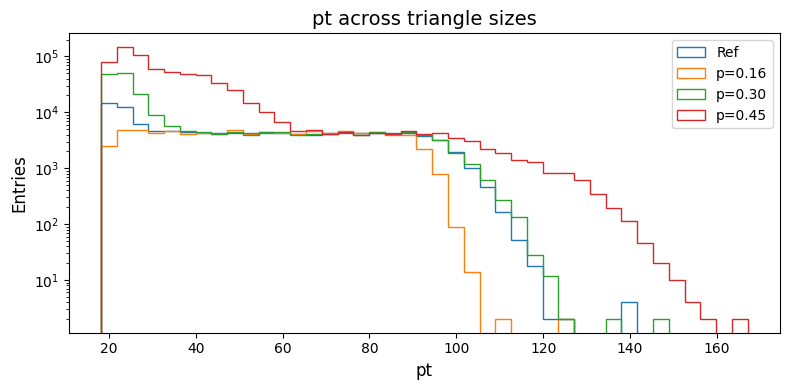

Saved: plots_triangles/energy_across_triangles.png


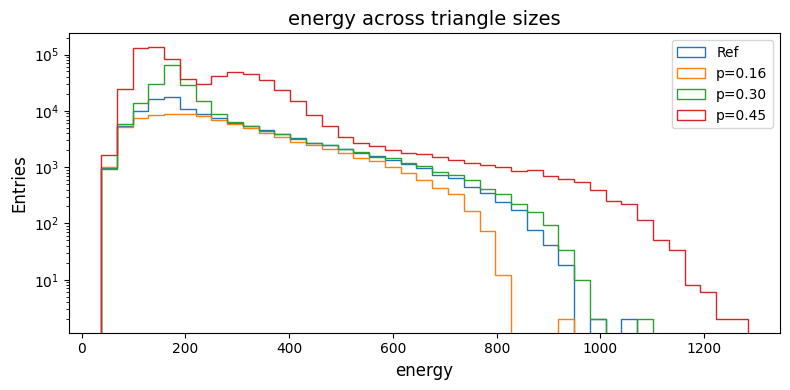

Saved: plots_triangles/eta_across_triangles.png


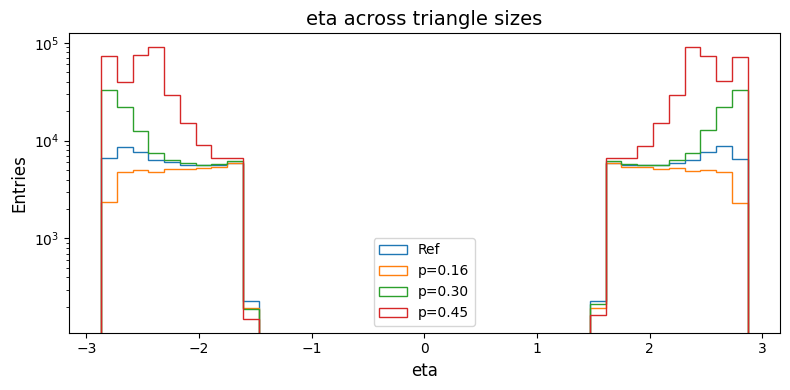

Saved: plots_triangles/phi_across_triangles.png


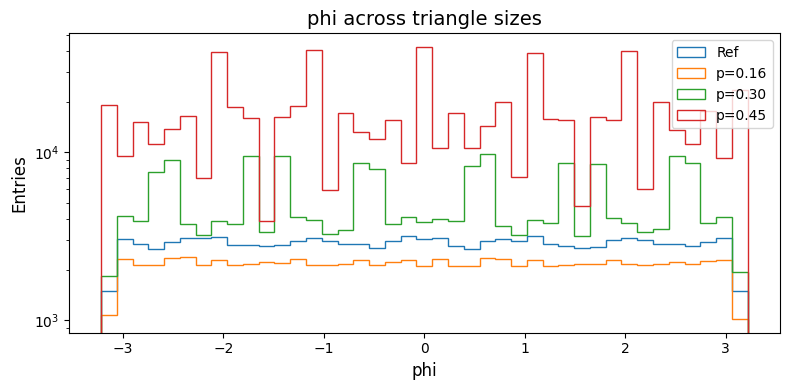

Saved: plots_triangles/emax1layers_across_triangles.png


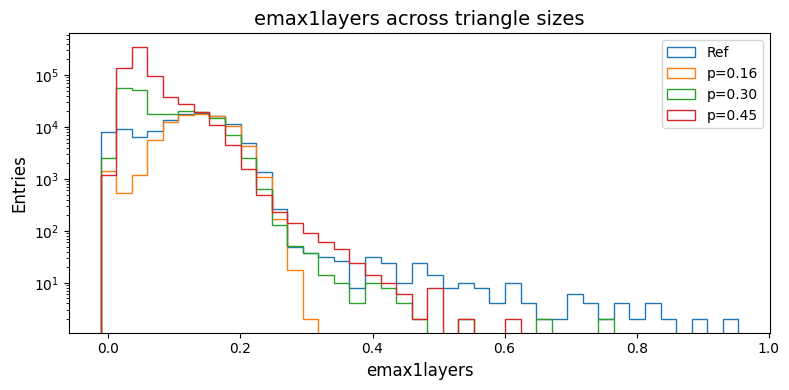

Saved: plots_triangles/emax3layers_across_triangles.png


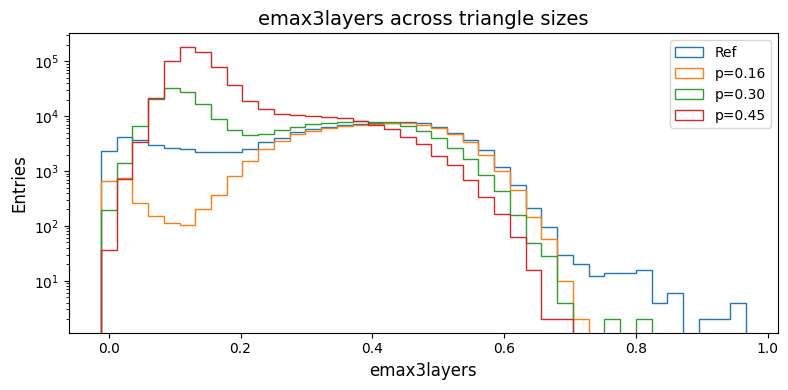

Saved: plots_triangles/showerlength_across_triangles.png


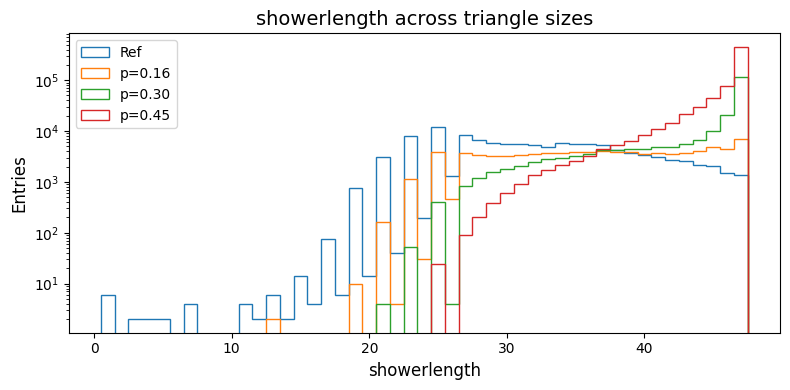

Saved: plots_triangles/coreshowerlength_across_triangles.png


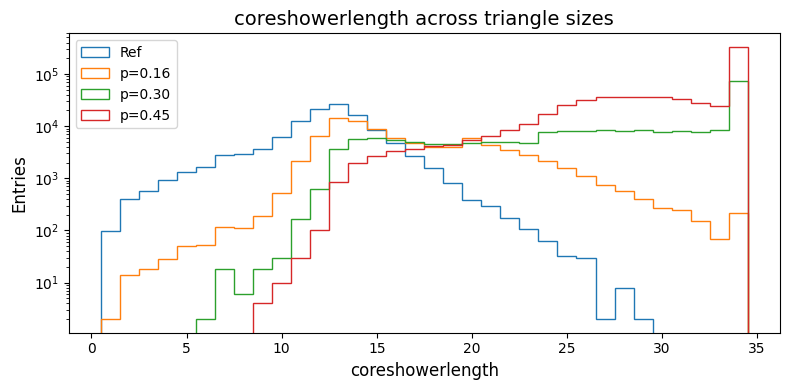

Saved: plots_triangles/firstlayer_across_triangles.png


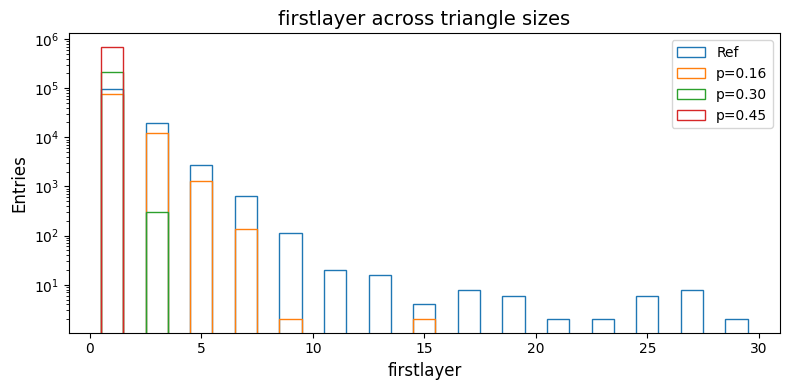

Saved: plots_triangles/maxlayer_across_triangles.png


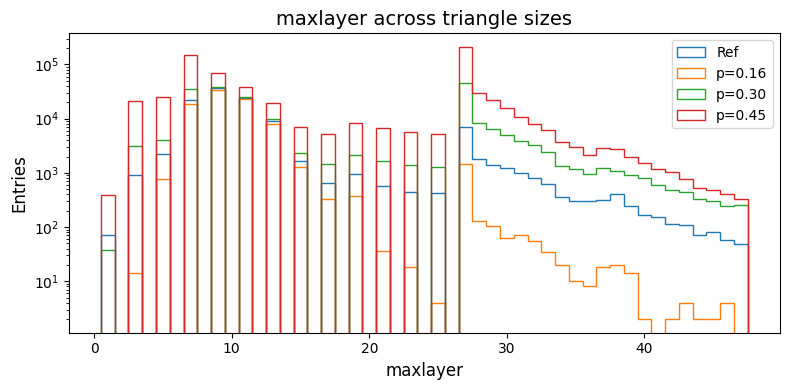

Saved: plots_triangles/varrr_across_triangles.png


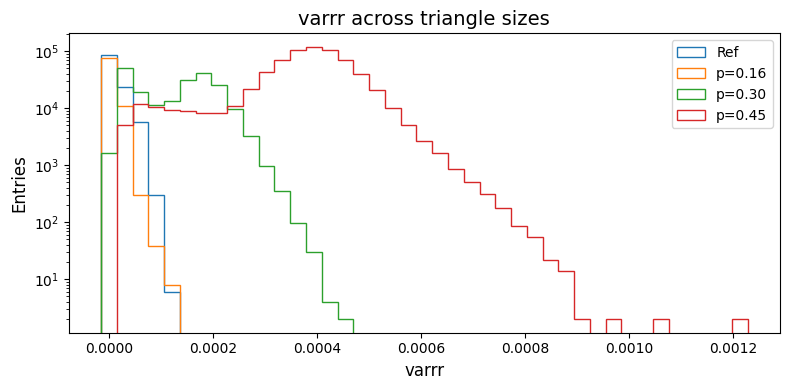

Saved: plots_triangles/varzz_across_triangles.png


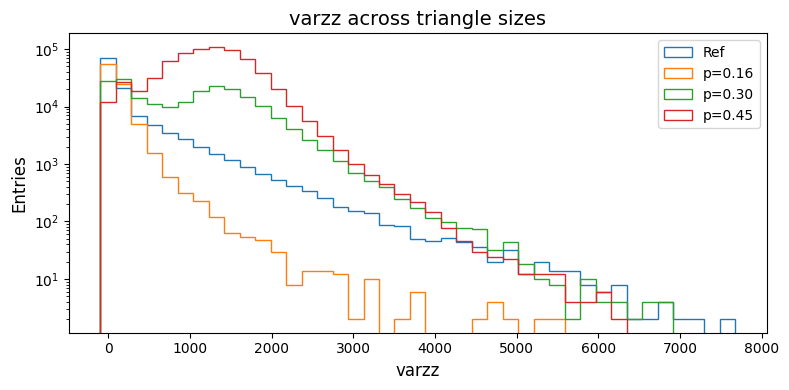

Saved: plots_triangles/varee_across_triangles.png


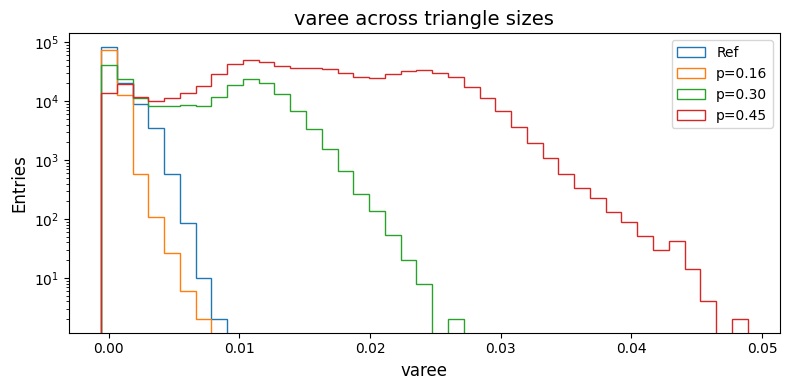

Saved: plots_triangles/varpp_across_triangles.png


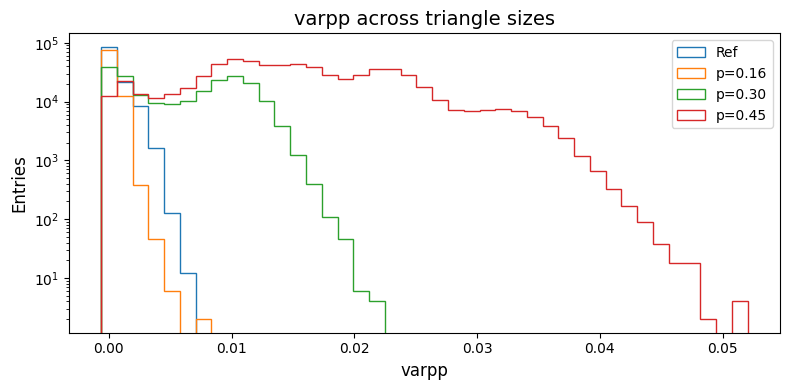

Saved: plots_triangles/emaxe_across_triangles.png


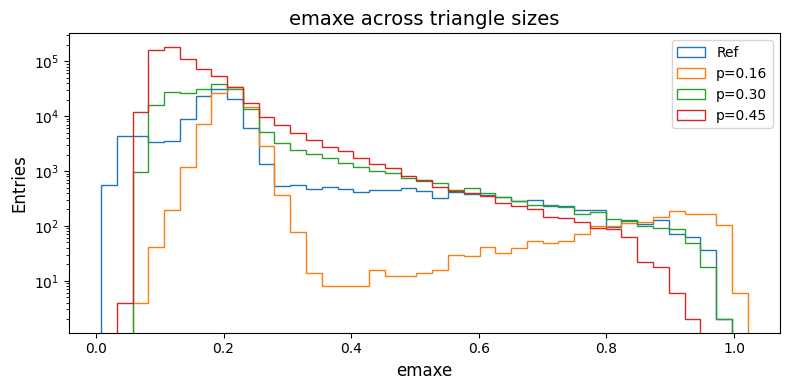

Saved: plots_triangles/hoe_across_triangles.png


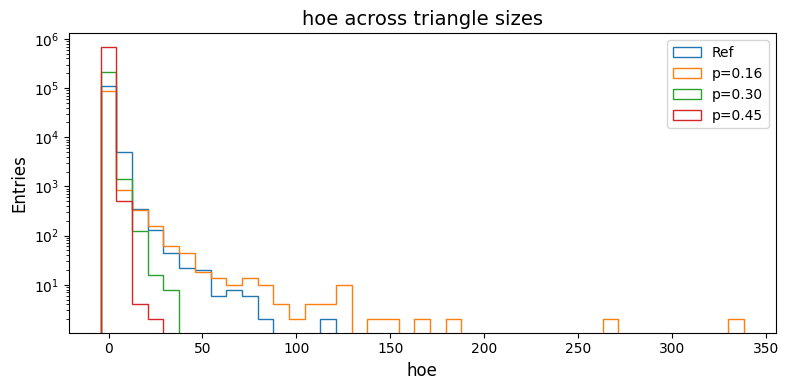

Saved: plots_triangles/meanz_across_triangles.png


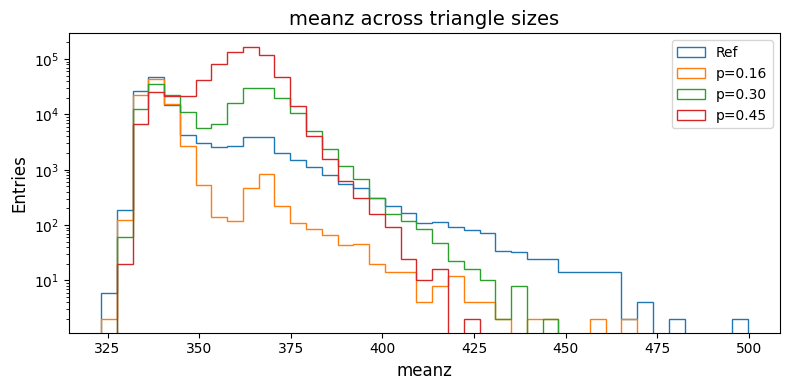

Saved: plots_triangles/first1layers_across_triangles.png


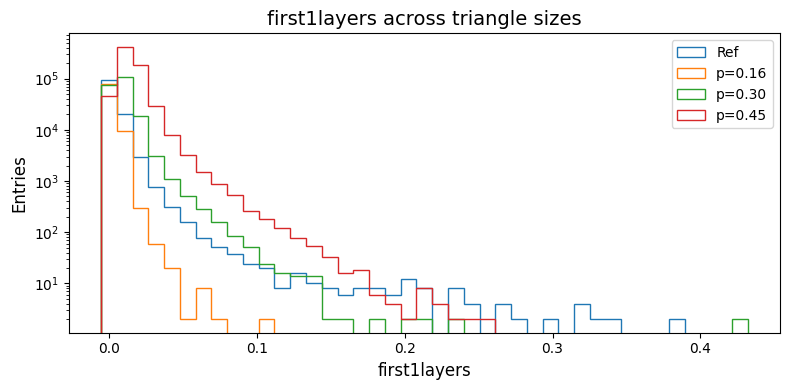

Saved: plots_triangles/first3layers_across_triangles.png


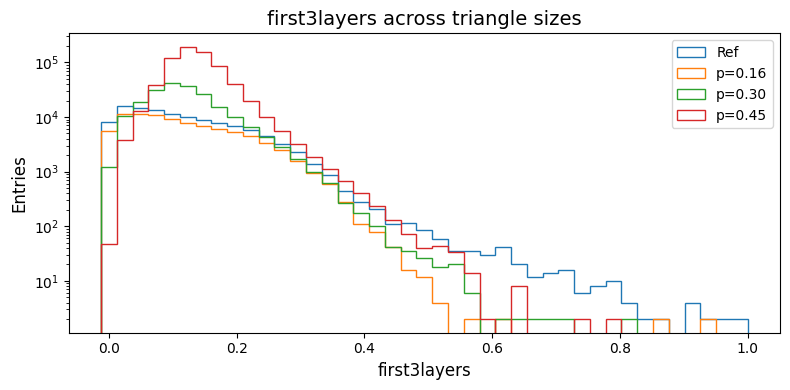

Saved: plots_triangles/first5layers_across_triangles.png


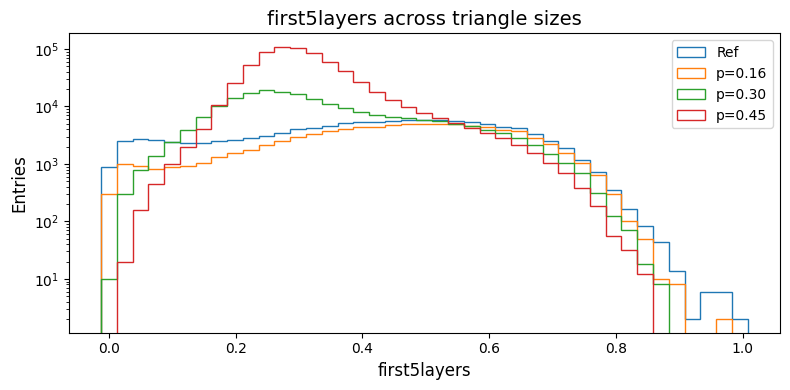

Saved: plots_triangles/firstHcal1layers_across_triangles.png


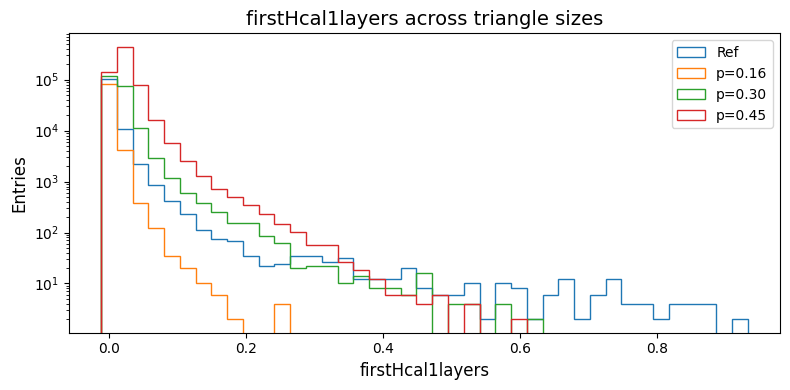

Saved: plots_triangles/firstHcal3layers_across_triangles.png


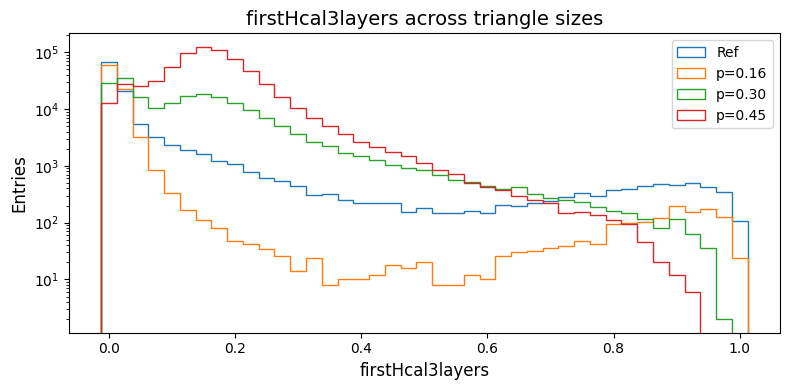

Saved: plots_triangles/firstHcal5layers_across_triangles.png


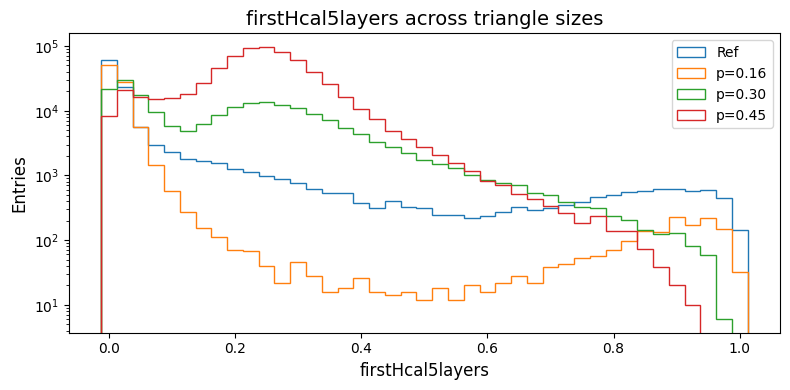

Saved: plots_triangles/last1layers_across_triangles.png


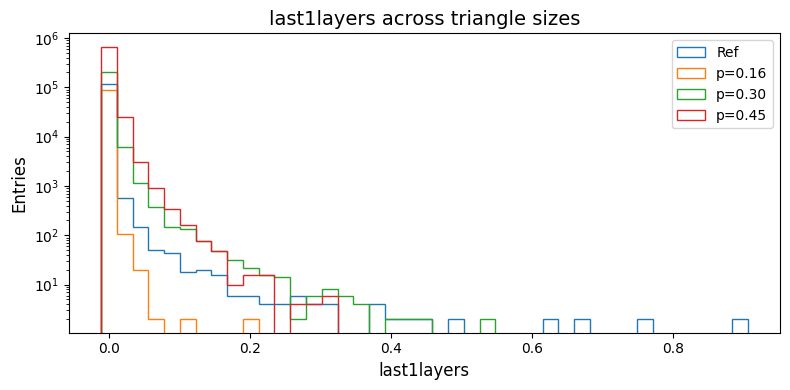

Saved: plots_triangles/last3layers_across_triangles.png


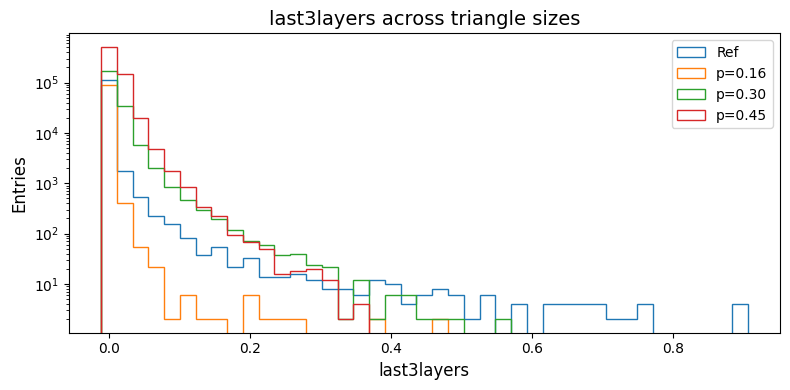

Saved: plots_triangles/last5layers_across_triangles.png


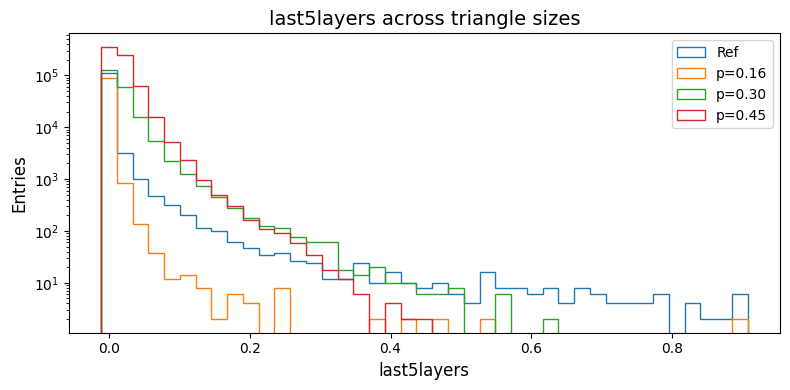

Saved: plots_triangles/eot_across_triangles.png


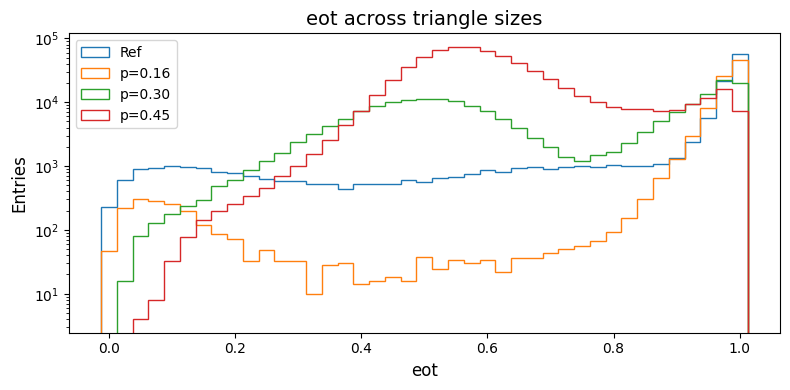

Saved: plots_triangles/ebm0_across_triangles.png


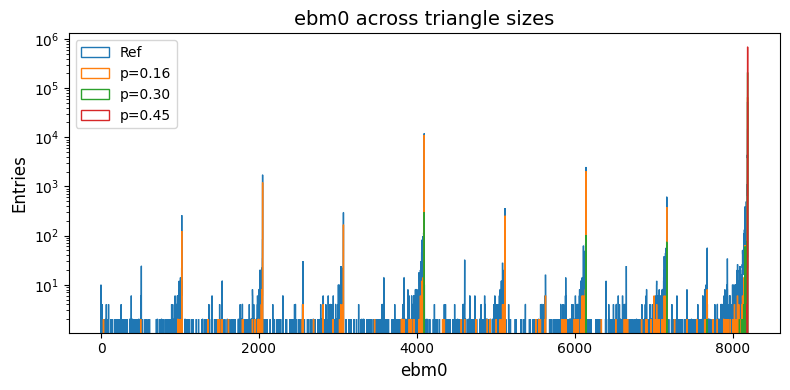

Saved: plots_triangles/ebm1_across_triangles.png


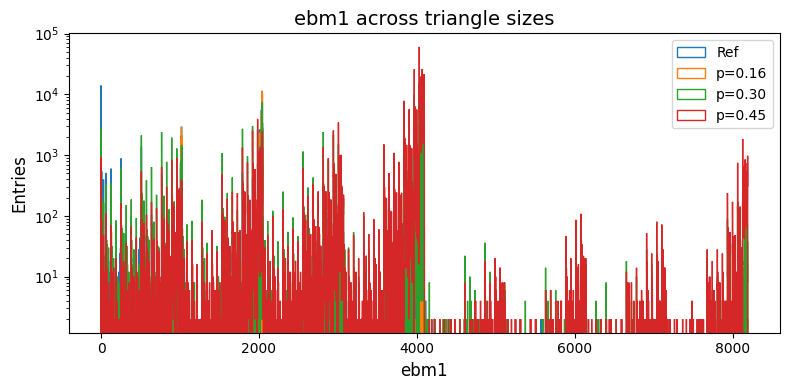

In [55]:
plot_across_four_lists(
    photon_df_Ref, photon_df_p016, photon_df_p03, photon_df_p045,
    ana.variables_to_plot('Ref'), ana.variables_to_plot('p016Tri'), ana.variables_to_plot('p03Tri'), ana.variables_to_plot('p045Tri'),   # full column names per DF
    label_ref="Ref", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plots_triangles",
    var_latex_map=None,                         # can map full name or suffix
    num_bins=40, cl3d_pt_range=(20, 200),
    pt_col_ref="cl3d_Ref_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None  # weight_cols: dict with keys "ref","p016","p03","p045"
)

In [ ]:
ana.plot_delta_r_3d_two_dfs(photon_df_p03_filtered, 'Photon PU200', "delta_Rplots", colors=('blue', 'red'))

Saved: newsamples_Ref_plots/cl3d_Ref_pt_histogram.png


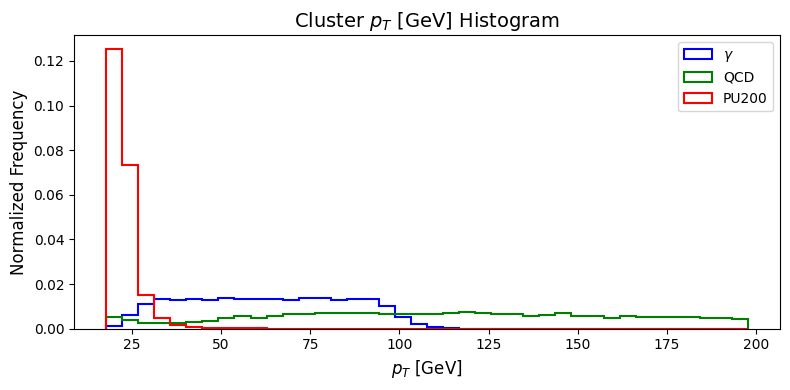

Saved: newsamples_Ref_plots/cl3d_Ref_energy_histogram.png


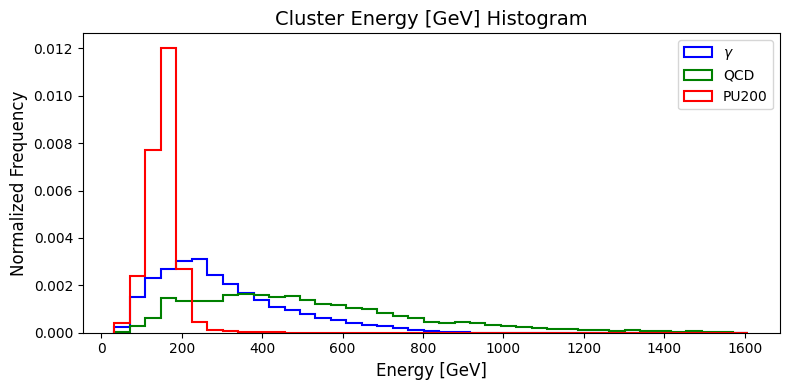

Saved: newsamples_Ref_plots/cl3d_Ref_eta_histogram.png


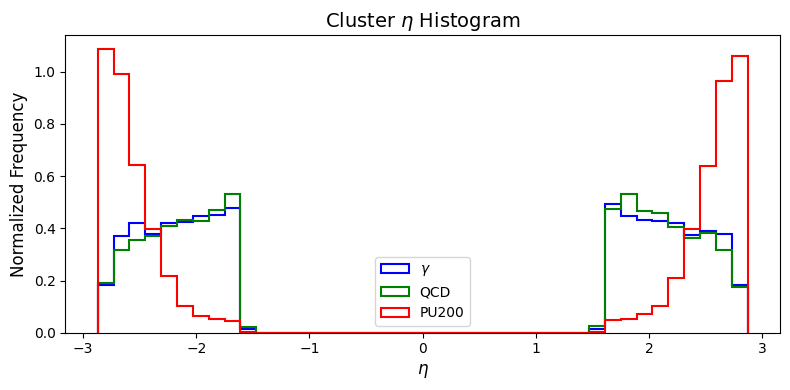

Saved: newsamples_Ref_plots/cl3d_Ref_phi_histogram.png


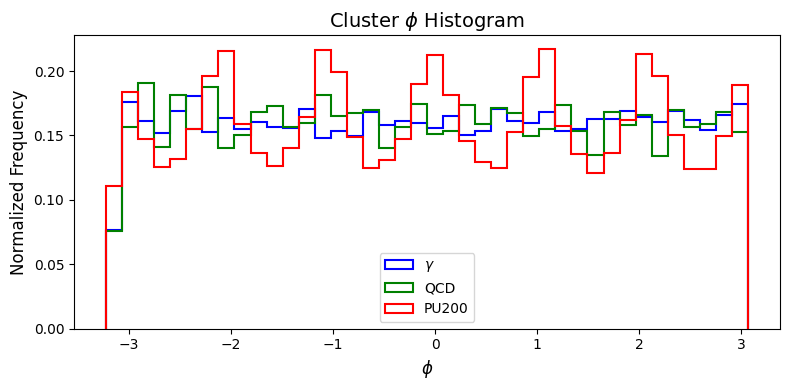

Saved: newsamples_Ref_plots/cl3d_Ref_emax1layers_histogram.png


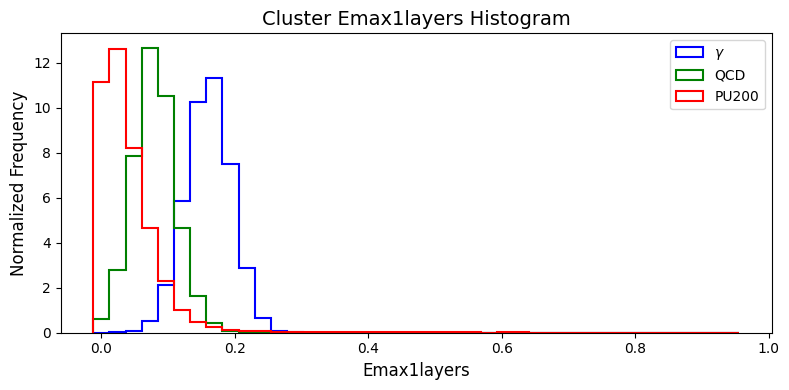

Saved: newsamples_Ref_plots/cl3d_Ref_emax3layers_histogram.png


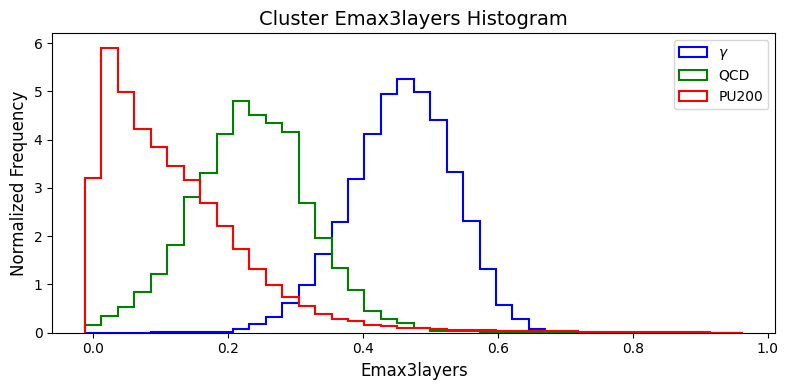

Saved: newsamples_Ref_plots/cl3d_Ref_showerlength_histogram.png


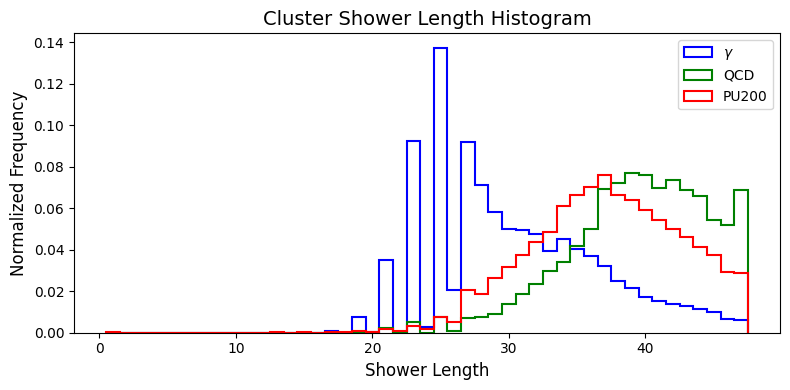

Saved: newsamples_Ref_plots/cl3d_Ref_coreshowerlength_histogram.png


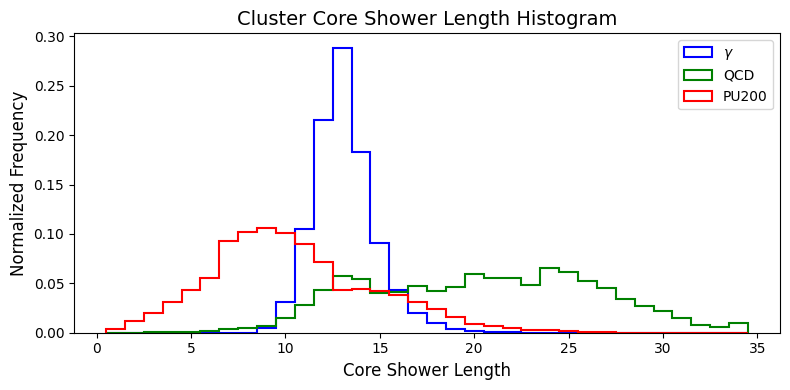

Saved: newsamples_Ref_plots/cl3d_Ref_firstlayer_histogram.png


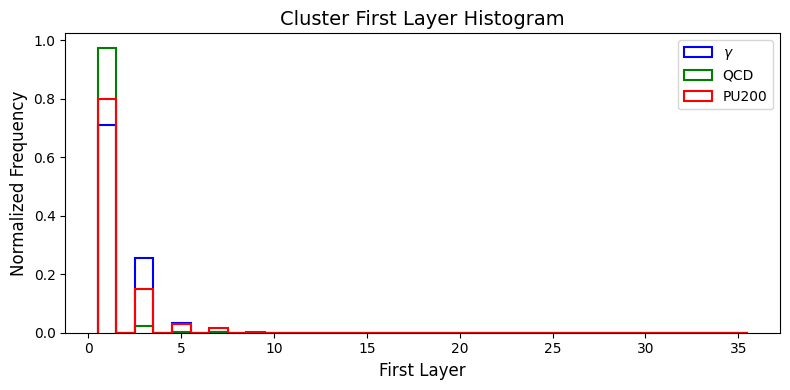

Saved: newsamples_Ref_plots/cl3d_Ref_maxlayer_histogram.png


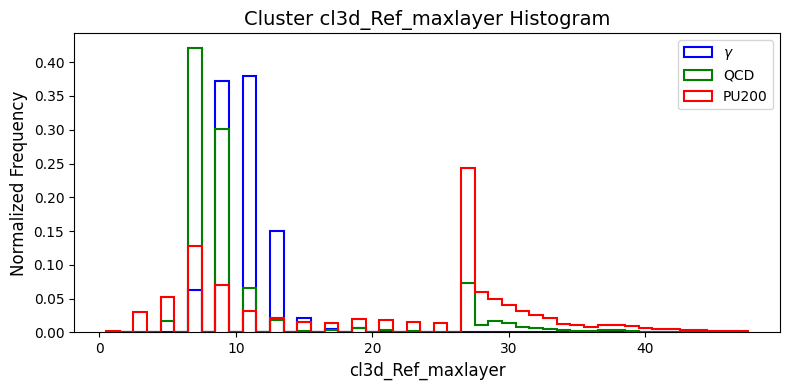

Saved: newsamples_Ref_plots/cl3d_Ref_varrr_histogram.png


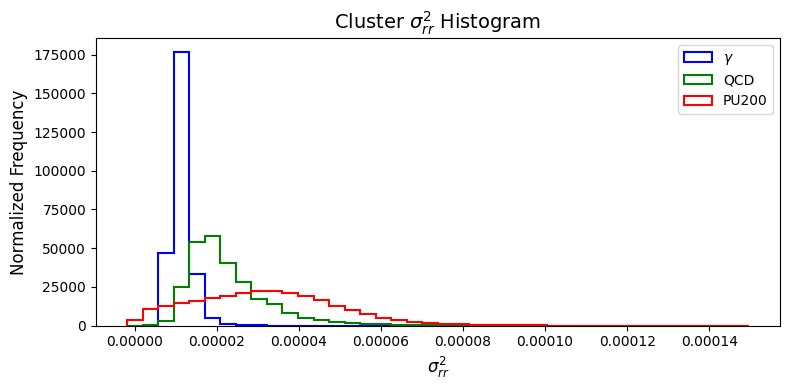

Saved: newsamples_Ref_plots/cl3d_Ref_varzz_histogram.png


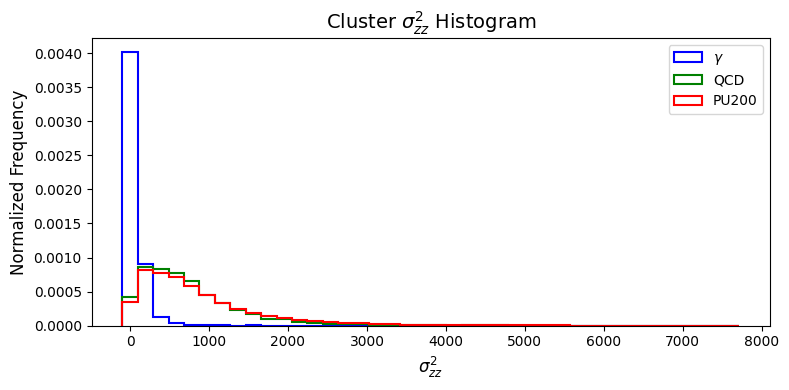

Saved: newsamples_Ref_plots/cl3d_Ref_varee_histogram.png


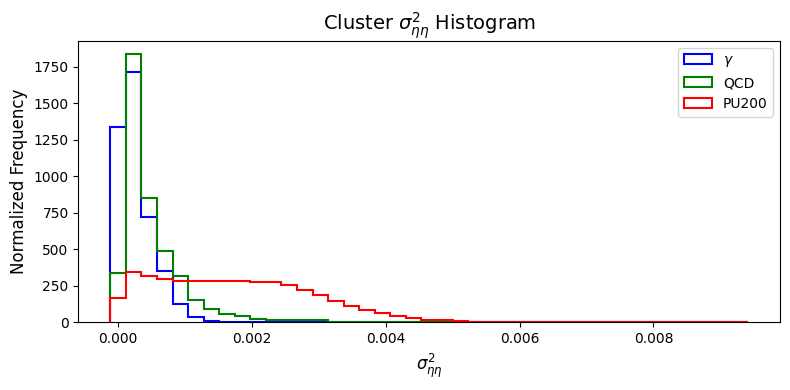

Saved: newsamples_Ref_plots/cl3d_Ref_varpp_histogram.png


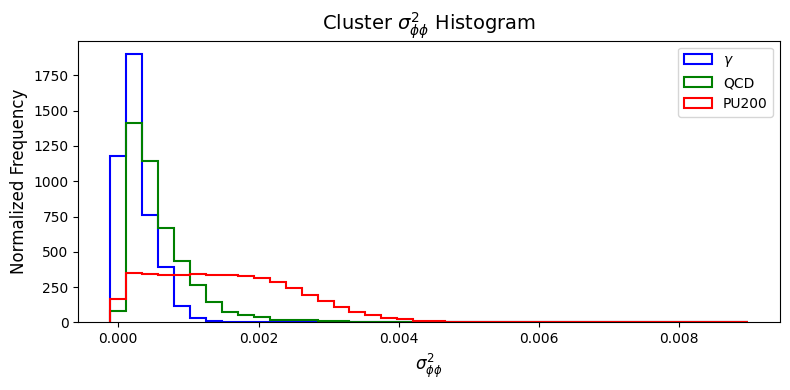

Saved: newsamples_Ref_plots/cl3d_Ref_emaxe_histogram.png


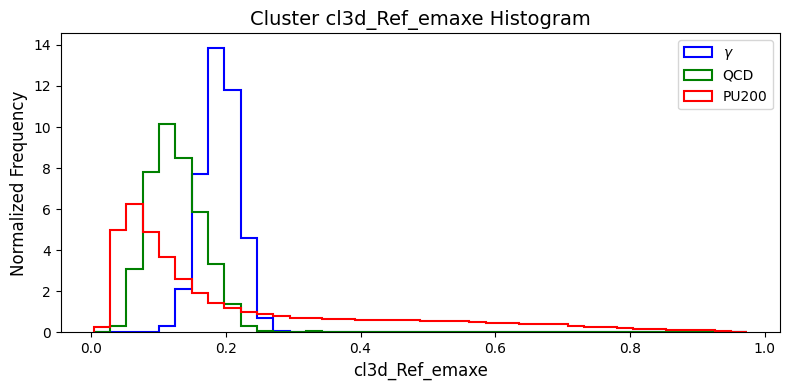

Saved: newsamples_Ref_plots/cl3d_Ref_hoe_histogram.png


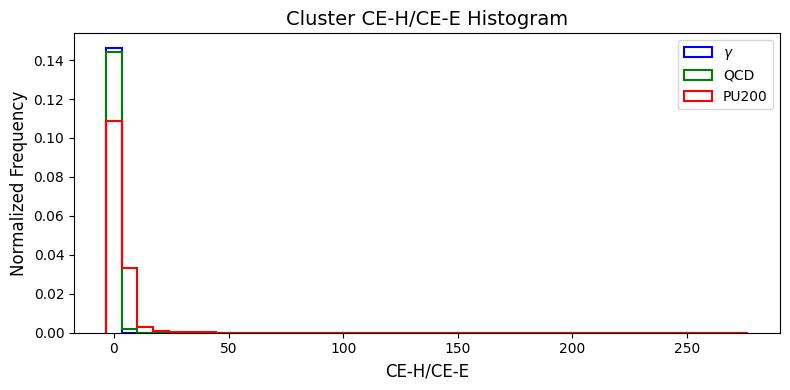

Saved: newsamples_Ref_plots/cl3d_Ref_meanz_histogram.png


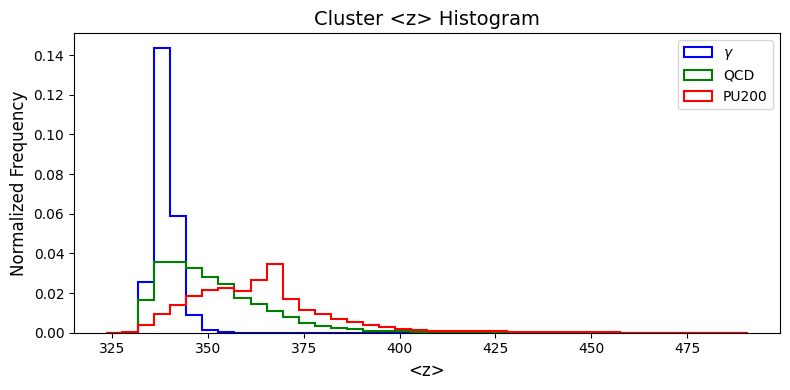

Saved: newsamples_Ref_plots/cl3d_Ref_first1layers_histogram.png


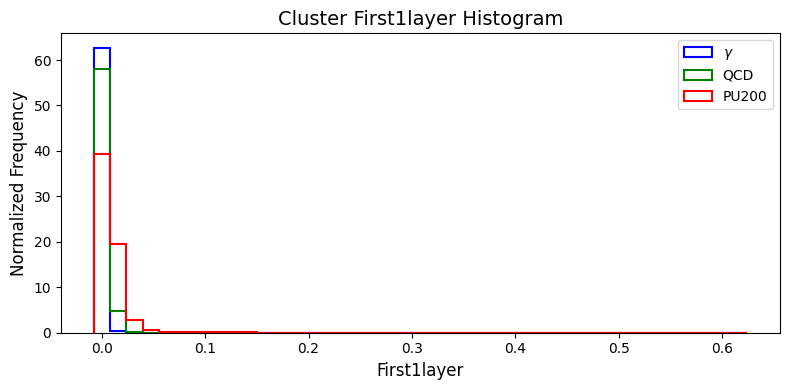

Saved: newsamples_Ref_plots/cl3d_Ref_first3layers_histogram.png


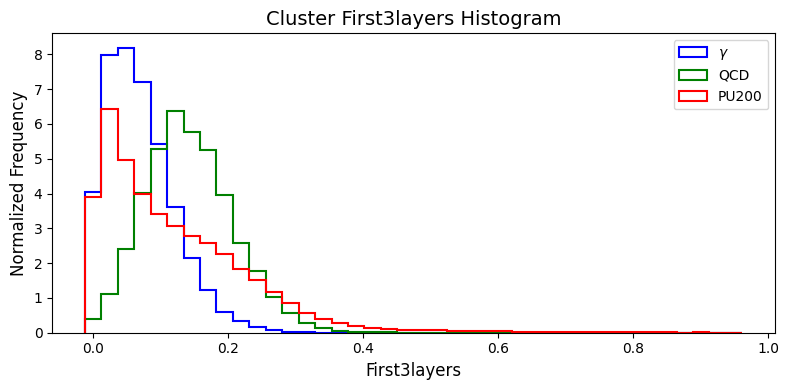

Saved: newsamples_Ref_plots/cl3d_Ref_first5layers_histogram.png


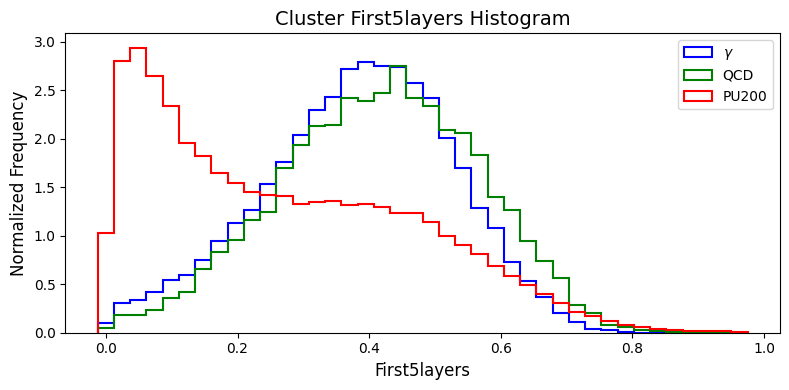

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal1layers_histogram.png


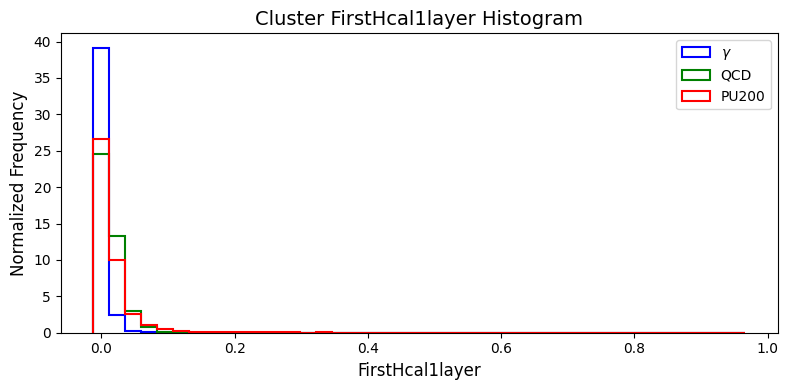

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal3layers_histogram.png


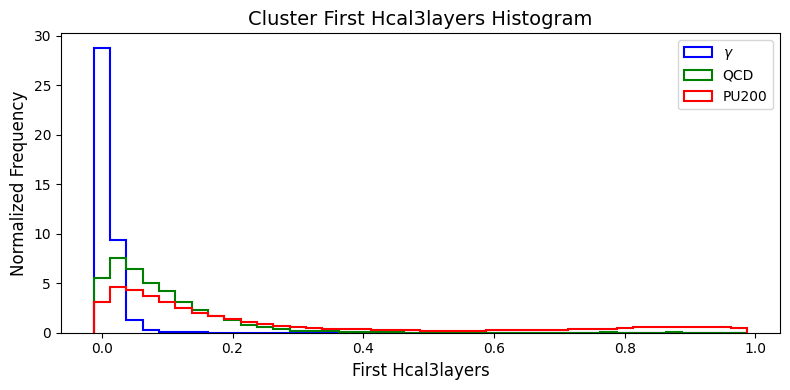

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal5layers_histogram.png


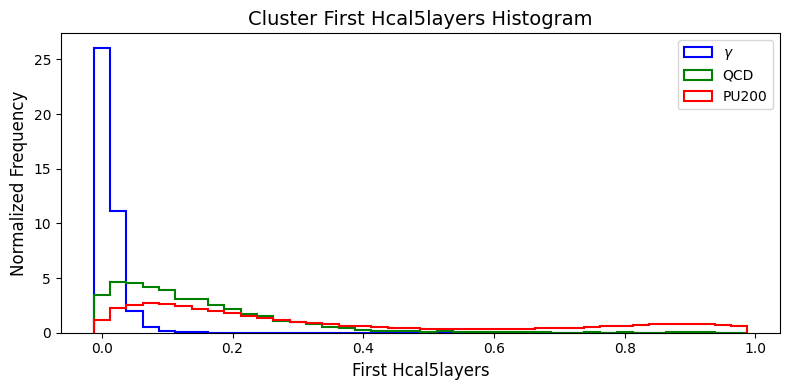

Saved: newsamples_Ref_plots/cl3d_Ref_last1layers_histogram.png


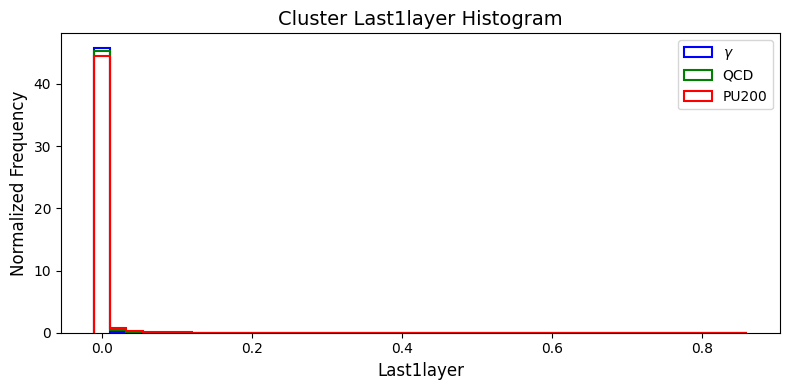

Saved: newsamples_Ref_plots/cl3d_Ref_last3layers_histogram.png


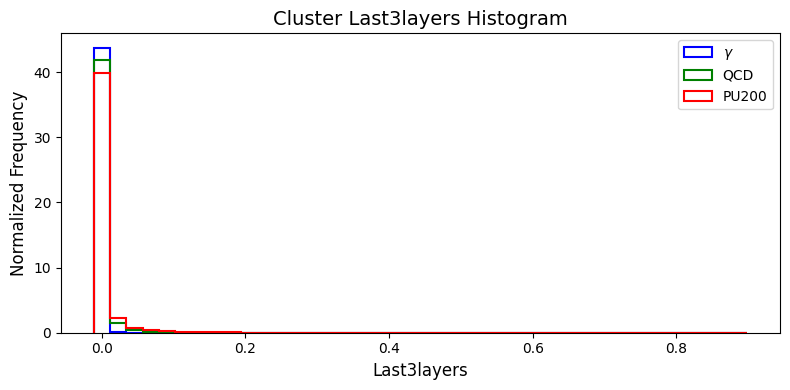

Saved: newsamples_Ref_plots/cl3d_Ref_last5layers_histogram.png


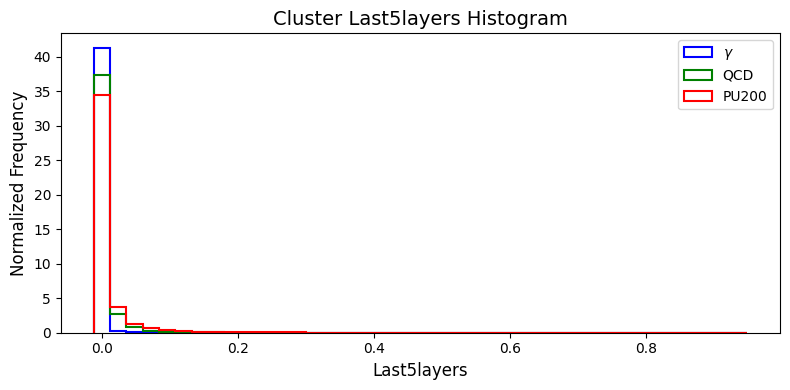

Saved: newsamples_Ref_plots/cl3d_Ref_eot_histogram.png


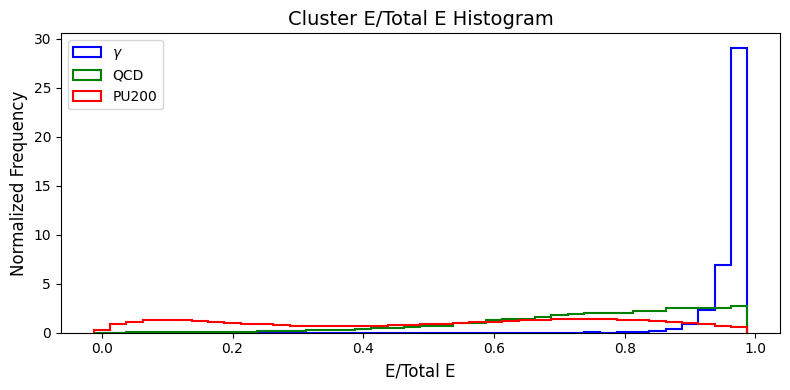

Saved: newsamples_Ref_plots/cl3d_Ref_ebm0_histogram.png


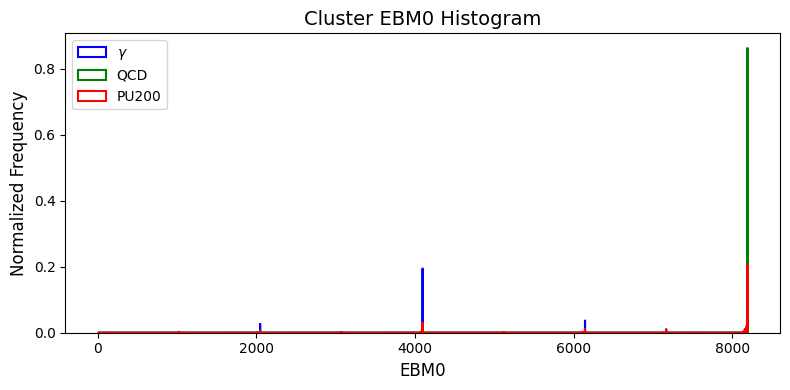

Saved: newsamples_Ref_plots/cl3d_Ref_ebm1_histogram.png


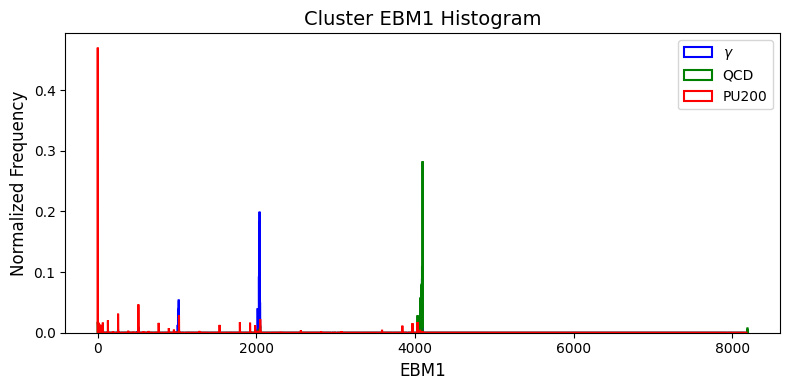

In [79]:
ana.plot_histograms(photon_df_Ref_filtered, qcd_df_Ref_filtered, PU_df_Ref, ana.variables_to_plot('Ref'), r'$\gamma$', 'QCD', 'PU200', 'newsamples_Ref_plots', ana.var_map('Ref'), 'Ref')

In [33]:
iteration = 0
for prec in [12]:
    for depth in [3, 4, 5]:
        for rounds in [10, 20, 40]:
            row = train_quantized_multiclass(prec, depth, rounds, iteration, X_train, y_train, X_test, y_test)
            result_table.loc[len(result_table)] = row
            result_table.to_csv("conifer_multiclass_opti.csv", index=False)
            iteration += 1

[0] Training model: precision=12, depth=3, rounds=10


xsim_compile.sh: line 1: xvhdl: command not found
xsim_compile.sh: line 2: xvhdl: command not found
xsim_compile.sh: line 3: xvhdl: command not found
xsim_compile.sh: line 4: xvhdl: command not found
xsim_compile.sh: line 5: xvhdl: command not found
xsim_compile.sh: line 6: xvhdl: command not found
xsim_compile.sh: line 7: xvhdl: command not found
xsim_compile.sh: line 8: xvhdl: command not found
xsim_compile.sh: line 9: xvhdl: command not found
xsim_compile.sh: line 10: xvhdl: command not found
xsim_compile.sh: line 12: xvhdl: command not found
xsim_compile.sh: line 13: xvhdl: command not found
xsim_compile.sh: line 14: xvhdl: command not found
xsim_compile.sh: line 16: xelab: command not found
'sim_compile' failed, check xsim_compile.log
sh: line 1: xsim: command not found
'sim_compile' failed, check xsim.log


AxisError: axis 1 is out of bounds for array of dimension 0